# Krzysztof Zakrzewski.
# Historical data EDA z JustJoinIT (10.2021 – 09.2023)

# About the dataset
### Job offer data from JustJoinIT (10.2021 – 09.2023)
## Data collected (scraped) from one of the largest Polish IT job platforms.

This dataset contains daily snapshots of job offers collected from JustJoinIT – one of the largest Polish platforms with IT job postings. The dataset includes a variety of offers related to programming languages and IT fields (Java, C#, Python, JavaScript, data engineering, and others).

Job offers were collected from an API endpoint that provided all available offers. I created a simple AWS Lambda function that was triggered once a day and saved the collected data to S3. The data is raw – the original JSON provided by the API was saved to S3 without any processing.

First recorded day of data: October 23, 2021

Last recorded day of data: September 25, 2023

The dataset is incomplete (due to the lack of a retry mechanism in the script). Missing days:

- 2022-06-05
- 2022-09-12
- 2022-10-03
- 2022-10-10
- 2022-10-14
- 2022-10-17
- 2022-10-22
- 2022-10-23
- 2022-10-25
- 2022-10-29
- 2022-11-06
- 2022-11-12
- 2022-11-13
- 2022-12-11
- 2022-12-18
- 2022-12-26
- 2023-02-04
- 2023-02-07
- 2023-02-08
- 2023-02-26
- 2023-03-11
- 2023-03-12
- 2023-03-27
- 2023-04-03
- 2023-04-12
- 2023-04-14
- 2023-04-17
- 2023-04-19
- 2023-04-20
- 2023-04-21
- 2023-04-22
- 2023-04-24

#### Link to data:
https://www.kaggle.com/datasets/jszafranqb/justjoinit-job-offers-data-2021-10-2023-09

#### Autor of data:
https://www.kaggle.com/jszafranqb


# Analysis goals:

1. What was the average lifetime of a job offer?
2. Were there periodic increases and decreases in the number of job offers?
3. Which technologies were the most popular?
4. What was the situation of the Python language?
5. How many junior-level job offers were there?
6. What was the number of junior job offers compared to company size?
7. What was the overall outline of salaries?

In [1]:
# Importy

import pandas as pd
import numpy as np
import re
from IPython.display import Markdown
from IPython.display import Markdown, display
from itables import show
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from collections import Counter

In [2]:
# Use only if next in cell dataframe is dowland to long

# df = pd.read_csv(
#     "https://jurek.fra1.digitaloceanspaces.com/masterclass/all_old_data.csv.gz",
#     sep=";",
#     encoding="utf-8",
#     compression="gzip",
#     nrows=5
# )
# df.head()

In [3]:
df = pd.read_csv("https://jurek.fra1.digitaloceanspaces.com/masterclass/all_old_data.csv.gz", sep=";", encoding="utf-8", compression="gzip", low_memory=False)
# show(df)

## Step 1. Technical data overview

In [4]:
Markdown(f"""
#### The data contains **{len(df)}** records and **{len(df.columns)}** columns.
""")


#### The data contains **229891** records and **19** columns.


In [5]:
df.describe()

salary_from      salary_to
count  158750.000000  158750.000000
mean    14906.849058   20618.906318
std      7249.012939    8933.532744
min       350.000000     400.000000
25%     10000.000000   15000.000000
50%     15000.000000   20500.000000
75%     20000.000000   26000.000000
max    290000.000000  390000.000000

### Basic information about the DataFrame

In [6]:
info_df = pd.DataFrame({
    'Column': df.columns,
    "Duplicates": df.duplicated().sum(),
    'Non-null': df.notnull().sum().values,
    'Missing values': df.isna().sum().values,
    'Percentage of missing values': (df.isna().sum() * 100 / df.notnull().sum()).values,
    'Unique values': df.nunique().values,
    'Data type': df.dtypes.values,
})

# Display the table
info_df

Column  Duplicates  Non-null  Missing values  \
0                     title           0    229891               0   
1                      city           0    229891               0   
2              country_code           0    229793              98   
3               marker_icon           0    229891               0   
4            workplace_type           0    229891               0   
5              company_name           0    229891               0   
6              company_size           0    229891               0   
7          experience_level           0    229891               0   
8          remote_interview           0    229891               0   
9                        id           0    229891               0   
10                   skills           0    229887               4   
11                   remote           0    229891               0   
12                     type           0    229891               0   
13              salary_from           0    158750           71141   
14                salary_to           0    158750           71141   
15          salary_currency           0    158750           71141   
16       published_at_first           0    229891               0   
17        published_at_last           0    229891               0   
18  open_to_hire_ukrainians           0    201776           28115   

    Percentage of missing values  Unique values Data type  
0                       0.000000          31654    object  
1                       0.000000           1575    object  
2                       0.042647             86    object  
3                       0.000000             24    object  
4                       0.000000              3    object  
5                       0.000000           7598    object  
6                       0.000000           1093    object  
7                       0.000000              3    object  
8                       0.000000              2      bool  
9                       0.000000         229891    object  
10                      0.001740          42769    object  
11                      0.000000              2      bool  
12                      0.000000              3    object  
13                     44.813228           1113   float64  
14                     44.813228           1327   float64  
15                     44.813228              5    object  
16                      0.000000         104064    object  
17                      0.000000          16413    object  
18                     13.933768              2    object

### Summary of the technical data review:

- The data contains missing values to a small or easily fixable extent.

- The number of NaN values in the “salary” columns directly defines the number of job offers without salary ranges (44.8%).

- The data does not contain duplicates.

- The columns “remote_interview” and “remote” have boolean values, so their content can be changed to a more user-friendly form.

- The column “open_to_hire_ukrainians” can have missing values replaced with “Unknown”.

- The column “country_code” requires research.

- The column “open_to_hire_ukrainians” requires fixing; the recommended method is replacing NaN values with “unknown”.

- The column “company_size” should be cleaned and converted to a numeric type.

- The columns “published_at_first” and “published_at_last” should be converted to DateTime format.

# Step 2. Data cleaning

#### Creating a copy of the DataFrame

In [7]:
df_fix = df.copy()

### 2.1 Column "city"

#### Capitalization of the "city" column

In [8]:
df_fix['city'] = df_fix['city'].str.capitalize()

#### 2.1.2 Removing incorrect city names

In [9]:
# Characters that should not appear in a city name
BAD_CHARS_PATTERN = r"[.,;:/\\_!@#$%^&*()+=?<>[\]{}|]"

def has_bad_chars(x):
    if not isinstance(x, str):
        return False
    return bool(re.search(BAD_CHARS_PATTERN, x))

df_fix["city_has_bad_chars"] = df_fix["city"].apply(has_bad_chars)

bad_values = df_fix.loc[df_fix["city_has_bad_chars"], "city"].unique()
bad_values

array(['St. gallen', 'Athlone, ireland', 'London/remote', 'St. louis',
       'Bangkok, thailand', 'Poland, remote', 'Alicante (alacant)',
       'Kalmar, sweden', 'Sofia, bulgaria', 'Schwedt/oder',
       'Remote/anywhere poland'], dtype=object)

In [10]:
df_fix = df_fix[~df_fix["city_has_bad_chars"]].copy()
df_fix = df_fix.loc[~df_fix["city_has_bad_chars"]].reset_index(drop=True)
# Removing a column ["city_has_bad_chars"]
df_fix = df_fix.drop(columns=["city_has_bad_chars"])


### 2.1.3 Fixing city names

### 2.2 Fixing column "country_code"

#### City names in records where missing values were detected in the "country_code" column

In [11]:
no_code_citys = df_fix[df_fix['country_code'].isna()]['city'].unique()
no_code_citys

array(['Kraków', 'Europe', 'Warszawa', 'Katowice', 'Warsaw', 'Błonie',
       'Poznań', 'Wrocław', 'Gdańsk', 'Lwów', 'Zielona góra', 'Lublin',
       'Szczecin', 'Łódź', 'European union', 'Windhuk', 'Munich',
       'Bukareszt', 'Lizbon', 'Zurych', 'Barcelona', 'Madryt', 'Berlin',
       'Amsterdam', 'Dniepr', 'Gorzów wielkopolski', 'Poznan', 'London',
       'Prisztina', 'Limassol'], dtype=object)

In [12]:
(df_fix['city'].isna().sum(), (df_fix['city'].str.strip() == '').sum())
df_fix.loc[df_fix['city'].str.strip() == '', ['city', 'country_code']].head()

Empty DataFrame
Columns: [city, country_code]
Index: []

#### 2.2.1 Standardizing cities recorded as "European Union"

In [13]:
df_fix.loc[df_fix["city"].isin(["European union", "Europe"]), "country_code"] = "EU"
df_fix.loc[df_fix["city"].isin(["Europe"]), "city"] = "European union"


In [14]:
# urk = df_fix[df_fix['city']=='Europe']
# show(urk)

#### 2.2.2 Adding appropriate country codes

In [15]:
df_fix.loc[df_fix["city"].isin(["Lwów", 'Dniepr']), "country_code"] = "UA"
df_fix.loc[df_fix["city"].isin(["Windhuk"]), "country_code"] = "NA"
df_fix.loc[df_fix["city"].isin(["Munich", 'Berlin']), "country_code"] = "DE"
df_fix.loc[df_fix["city"].isin(["Bukareszt"]), "country_code"] = "RO"
df_fix.loc[df_fix["city"].isin(['Lizbon']), "country_code"] = "PT"
df_fix.loc[df_fix["city"].isin(["Zurych"]), "country_code"] = "CH"
df_fix.loc[df_fix["city"].isin(["Barcelona", 'Madryt']), "country_code"] = "ES"
df_fix.loc[df_fix["city"].isin(["Amsterdam"]), "country_code"] = "NL"
df_fix.loc[df_fix["city"].isin(["London", "Manchester"]), "country_code"] = "BG"
df_fix.loc[df_fix["city"].isin(["Prisztina"]), "country_code"] = "XK"
df_fix.loc[df_fix["city"].isin(["Limassol"]), "country_code"] = "CY"

polish_cities = df_fix.loc[df_fix['country_code'].isna(), 'city'].unique()
df_fix.loc[df_fix['city'].isin(polish_cities), 'country_code'] = 'PL'

In [16]:
# urk = df[df['salary_currency']!='pln']
# urk = df_fix[df_fix['country_code'].isna()]
# show(urk)

#### 2.3 Column "open_to_hire_ukrainians"

#### 2.3.1 Replacing NaN with the value "Unknown" and assigning readable aliases

In [17]:
df_fix['open_to_hire_ukrainians'] = df['open_to_hire_ukrainians'].fillna("Unknown")
df_fix['open_to_hire_ukrainians'] = df_fix['open_to_hire_ukrainians'].replace({True: 'Open to Ukrainians', False: 'Does not matter'})

### 2.4 Column "skills"

### 2.4.1 Removing records with NaN values

In [18]:
df_fix = df_fix.dropna(subset=["skills"])

### 2.5. Column "company_size"

#### Converting values from type "string" (text) to "int" (integer)

In [19]:
# 1. Remove commas, spaces, +, <, >, =, periods
df_fix['company_size'] = df_fix['company_size'].str.replace(r'[,\s\+\<\>\=\.]', '', regex=True)

# 2. If there is a range like '10-20', keep only the part after the hyphen
df_fix['company_size'] = df_fix['company_size'].str.split('-').str[-1]

# 3. Remove any remaining hyphens (just in case)
df_fix['company_size'] = df_fix['company_size'].str.replace('-', '', regex=True)

# 4. Convert to a number (int)
df_fix['company_size'] = pd.to_numeric(df_fix['company_size'], errors='coerce')

### 2.6 Time columns

#### 2.6.1 Keeping data with second-level precision and converting to datetime format

In [20]:
df_fix['published_at_first'] = df_fix['published_at_first'].astype(str).str[:19]
df_fix['published_at_last']  = df_fix['published_at_last'].astype(str).str[:19]

df_fix['published_at_first'] = pd.to_datetime(df_fix['published_at_first'], errors='coerce')
df_fix['published_at_last']  = pd.to_datetime(df_fix['published_at_last'], errors='coerce')


#### 2.6.2 Checking how many records were loaded and removed within the same second

In [21]:
publish_wanish = df_fix[df_fix['published_at_first'] == df_fix['published_at_last']]
publish_wanish.shape[0]
df_all_records = len(df_fix)

Markdown(f'#### There are **{publish_wanish.shape[0]}** records that were loaded and removed in the same exact second, which accounts for {((publish_wanish.shape[0]*100)/df_all_records):.2f}% of all records.<br>These are test or incorrect data and should be removed.')

#### There are **4553** records that were loaded and removed in the same exact second, which accounts for 1.98% of all records.<br>These are test or incorrect data and should be removed.

#### 2.6.3 Removing records loaded and removed in the same second

In [22]:
df_fix = df_fix[df_fix['published_at_first'] != df_fix['published_at_last']]
print(f'Number of remaining records: {len(df_fix)}')

Number of remaining records: 225319


#### 2.6.4 Sorting data by the "published_at_first" column

In [23]:
df_fix = df_fix.sort_values(by='published_at_first')
df_fix = df_fix.reset_index(drop=True)

In [24]:
# first_publish =  df_fix['published_at_first'].min()

# first_publish

#### 2.6.5 Removing records shorter than one day

In [25]:
df_fix['lifetime_in_days'] = (
    df_fix['published_at_last'] - df_fix['published_at_first']
).dt.total_seconds() / 86400  # in hours
df_fix['lifetime_in_days'].describe()

count    225319.000000
mean         43.317638
std          55.282574
min           0.000012
25%          24.016134
50%          25.021644
75%          39.991204
max         716.999444
Name: lifetime_in_days, dtype: float64

In [26]:
on_day_offer = df_fix.loc[(df_fix['lifetime_in_days'] <=1)]
more_than_90_days_offer = df_fix.loc[(df_fix['lifetime_in_days'] >365)]
Markdown(f'#### There are {len(on_day_offer)} unlikely job offers shorter than 1 day.<br>There are {len(more_than_90_days_offer)} offers longer than 365 days.')

#### There are 444 unlikely job offers shorter than 1 day.<br>There are 1389 offers longer than 365 days.

In [27]:
df_fix = df_fix[df_fix['lifetime_in_days'] >= 1]

#### 2.7.1 Replacing True and False with more user-friendly names in the "remote_interview" and "remote" columns

In [28]:
# Change type for object
df_fix['remote'] = df_fix['remote'].astype(object)
df_fix['remote_interview'] = df_fix['remote_interview'].astype(object)

df_fix['remote'] = df_fix['remote'].replace({True: 'Remote', False: 'On-site'})
df_fix['remote_interview'] = df_fix['remote_interview'].replace({True: 'Remote interview', False: 'On-site interview'})


### Summary of Step 2: "Data Cleaning"

- Missing values were removed.
- The number of NaN values in the “salary” columns directly defines the number of job offers without salary ranges (44.8%).
- The data does not contain duplicates.
- The columns “remote_interview” and “remote” had boolean values and were changed to more user-friendly names.
- The column “open_to_hire_ukrainians” had NaN values replaced with “Unknown”, which facilitates analysis.
- The column “country_code” was updated with the appropriate country abbreviations.
- The column “company_size” was cleaned and converted to a numeric type.
- The columns “published_at_first” and “published_at_last” were converted to DateTime format, and unreliable records were removed.

In [29]:
info_df_fix = pd.DataFrame({
    'Column': df_fix.columns,
    "Duplicates": df_fix.duplicated().sum(),
    'Non-null': df_fix.notnull().sum().values,
    'Missing values': df_fix.isna().sum().values,
    'Percentage of missing values': (df_fix.isna().sum() * 100 / df_fix.notnull().sum()).values,
    'Unique values': df_fix.nunique().values,
    'Data type': df_fix.dtypes.values,
})

# Display the table
info_df_fix


Column  Duplicates  Non-null  Missing values  \
0                     title           0    224875               0   
1                      city           0    224875               0   
2              country_code           0    224875               0   
3               marker_icon           0    224875               0   
4            workplace_type           0    224875               0   
5              company_name           0    224875               0   
6              company_size           0    224772             103   
7          experience_level           0    224875               0   
8          remote_interview           0    224875               0   
9                        id           0    224875               0   
10                   skills           0    224875               0   
11                   remote           0    224875               0   
12                     type           0    224875               0   
13              salary_from           0    155354           69521   
14                salary_to           0    155354           69521   
15          salary_currency           0    155354           69521   
16       published_at_first           0    224875               0   
17        published_at_last           0    224875               0   
18  open_to_hire_ukrainians           0    224875               0   
19         lifetime_in_days           0    224875               0   

    Percentage of missing values  Unique values       Data type  
0                       0.000000          31010          object  
1                       0.000000           1537          object  
2                       0.000000             84          object  
3                       0.000000             24          object  
4                       0.000000              3          object  
5                       0.000000           7493          object  
6                       0.045824            303         float64  
7                       0.000000              3          object  
8                       0.000000              2          object  
9                       0.000000         224875          object  
10                      0.000000          41970          object  
11                      0.000000              2          object  
12                      0.000000              3          object  
13                     44.750055           1097         float64  
14                     44.750055           1309         float64  
15                     44.750055              5          object  
16                      0.000000         102124  datetime64[ns]  
17                      0.000000          13704  datetime64[ns]  
18                      0.000000              3          object  
19                      0.000000          60446         float64

In [30]:
Markdown(f'#### The original DataFrame had {len(df)} records. After cleaning, {len(df_fix)} records remain. It was reduced by {(100 - (len(df_fix)*100/(len(df)))):.2f}%.')

#### The original DataFrame had 229891 records. After cleaning, 224875 records remain. It was reduced by 2.18%.

## Krok 3. Single variable analysis


## 3.1 Analysis of publication times.

### 3.1.1 Descriptive data and further modifications

In [31]:
lifetime_stats = df_fix['lifetime_in_days'].describe().to_frame(name='lifetime_in_days')
lifetime_stats = lifetime_stats.round(2)
lifetime_stats.index = [
    'Number of offers', 'Average lifetime', 'Standard deviation', 'Shortest offer',
    '25%', '50%', '75%', 'Longest offer'
]

lifetime_stats

lifetime_in_days
Number of offers           224875.00
Average lifetime               43.40
Standard deviation             55.30
Shortest offer                  1.00
25%                            24.02
50%                            25.02
75%                            39.99
Longest offer                 717.00

#### Key insights (lifetime_in_days)

- The typical lifetime of a job offer is around 25 days, corresponding to a standard 3–5 week IT recruitment cycle.

- The mean (43 days) is significantly skewed by offers remaining open for months, and even over 700 days, indicating outliers and data errors.

- 75% of offers disappear before day 40, so longer-active listings may require optimization.

- For reliable analyses, it is recommended to use offers with a lifetime <180 days to avoid distortions.

Offers longer than 180 days may indicate:

- errors in the source,

- renewed postings,

- permanent positions rather than actual recruitment.

In [32]:
mean_life_time_days = df_fix['lifetime_in_days'].mean().round(2)
Markdown(f'#### The average lifetime of a job offer is {mean_life_time_days} days')


#### The average lifetime of a job offer is 43.4 days

In [33]:
df_clean = df_fix[df_fix['lifetime_in_days'] > 1]
print("Over 180 days:", (df_clean['lifetime_in_days'] > 180).sum())
print("Over 290 days:", (df_clean['lifetime_in_days'] > 290).sum())
print("Over 365 days:", (df_clean['lifetime_in_days'] > 365).sum())

Over 180 days: 6542
Over 290 days: 2401
Over 365 days: 1389


#### 3.1.2 Removing offers longer than 180 days

In [34]:
df_cut = df_fix[df_fix['lifetime_in_days'] >= 1]
df_cut = df_cut[df_cut['lifetime_in_days'] <= 180]


In [35]:
lifetime_stats_cut = df_cut['lifetime_in_days'].describe().to_frame(name='lifetime_in_days_less_than_180days')
lifetime_stats_cut = lifetime_stats_cut.round(2)
lifetime_stats_cut.index = [
    'Number of offers', 'Average lifetime', 'Standard deviation', 'Shortest offer',
    '25%', '50%', '75%', 'Longest offer'
]

lifetime_stats_cut

lifetime_in_days_less_than_180days
Number of offers                             218333.00
Average lifetime                                 35.79
Standard deviation                               27.88
Shortest offer                                    1.00
25%                                              24.01
50%                                              25.02
75%                                              35.00
Longest offer                                   179.99

#### The average lifetime of a job offer was **35.79** days

In [36]:
less_than_35 = df_cut[df_cut['lifetime_in_days'] <= 35]

between_35_60 = df_cut[(df_cut['lifetime_in_days'] > 35) & 
                       (df_cut['lifetime_in_days'] <= 60)]

between_60_90 = df_cut[(df_cut['lifetime_in_days'] > 60) & 
                       (df_cut['lifetime_in_days'] <= 90)]

between_90_120 = df_cut[(df_cut['lifetime_in_days'] > 90) & 
                        (df_cut['lifetime_in_days'] <= 120)]

above_120 = df_cut[df_cut['lifetime_in_days'] > 120]

print(
    f"Number of offers 0–35 days: {len(less_than_35)} ({len(less_than_35)*100/len(df_cut):.2f}%)\n"
    f"Number of offers 36–60 days: {len(between_35_60)} ({len(between_35_60)*100/len(df_cut):.2f}%)\n"
    f"Number of offers 61–90 days: {len(between_60_90)} ({len(between_60_90)*100/len(df_cut):.2f}%)\n"
    f"Number of offers 91–120 days: {len(between_90_120)} ({len(between_90_120)*100/len(df_cut):.2f}%)\n"
    f"Number of offers over 120 days: {len(above_120)} ({len(above_120)*100/len(df_cut):.2f}%)"
)


Number of offers 0–35 days: 163638 (74.95%)
Number of offers 36–60 days: 27740 (12.71%)
Number of offers 61–90 days: 13356 (6.12%)
Number of offers 91–120 days: 7115 (3.26%)
Number of offers over 120 days: 6484 (2.97%)


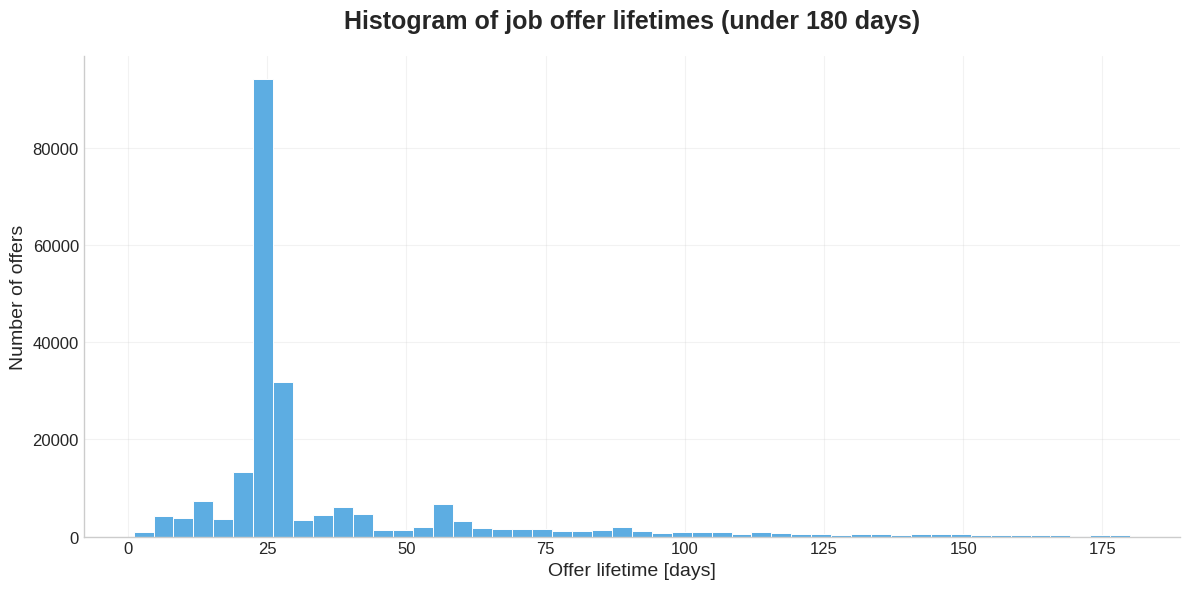

In [37]:
plt.style.use('seaborn-v0_8-whitegrid')  # clean, aesthetic look

fig, ax = plt.subplots(figsize=(12,6))

# Histogram
ax.hist(
    df_cut['lifetime_in_days'], 
    bins=50, 
    color='#5DADE2', 
    edgecolor='white',
    linewidth=0.7
)

# Title and labels
ax.set_title(
    'Histogram of job offer lifetimes (under 180 days)',
    fontsize=18, fontweight='bold', pad=20
)
ax.set_xlabel('Offer lifetime [days]', fontsize=14)
ax.set_ylabel('Number of offers', fontsize=14)

# Axis style
ax.tick_params(axis='both', labelsize=12)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Light grid
ax.grid(True, alpha=0.25)

plt.tight_layout()
plt.show()

#### 3.1.3 Number of offers by month

In [38]:
df_cut['year'] = df_cut['published_at_first'].dt.year
df_cut['month'] = df_cut['published_at_first'].dt.month

# Grouping and counting records
monthly_counts = df_cut.groupby(['year', 'month']).size().reset_index(name='number_of_records')

monthly_counts


year  month  number_of_records
0   2021      9                  4
1   2021     10               6116
2   2021     11               4547
3   2021     12               3646
4   2022      1               4664
5   2022      2               5804
6   2022      3               7229
7   2022      4               7449
8   2022      5               8900
9   2022      6              10024
10  2022      7              10971
11  2022      8              13099
12  2022      9              13275
13  2022     10              12070
14  2022     11              10912
15  2022     12               7121
16  2023      1              11595
17  2023      2              11054
18  2023      3              12479
19  2023      4              10747
20  2023      5              11222
21  2023      6               9452
22  2023      7               9241
23  2023      8              10482
24  2023      9               6230

September 2021 has 4 records. They may distort the statistics, so they will be removed.

In [39]:
df_cut = df_cut[
    ~(
        (df_cut['published_at_first'].dt.year == 2021) &
        (df_cut['published_at_first'].dt.month == 9)
    )
]


### Monthly aggregation on the offers

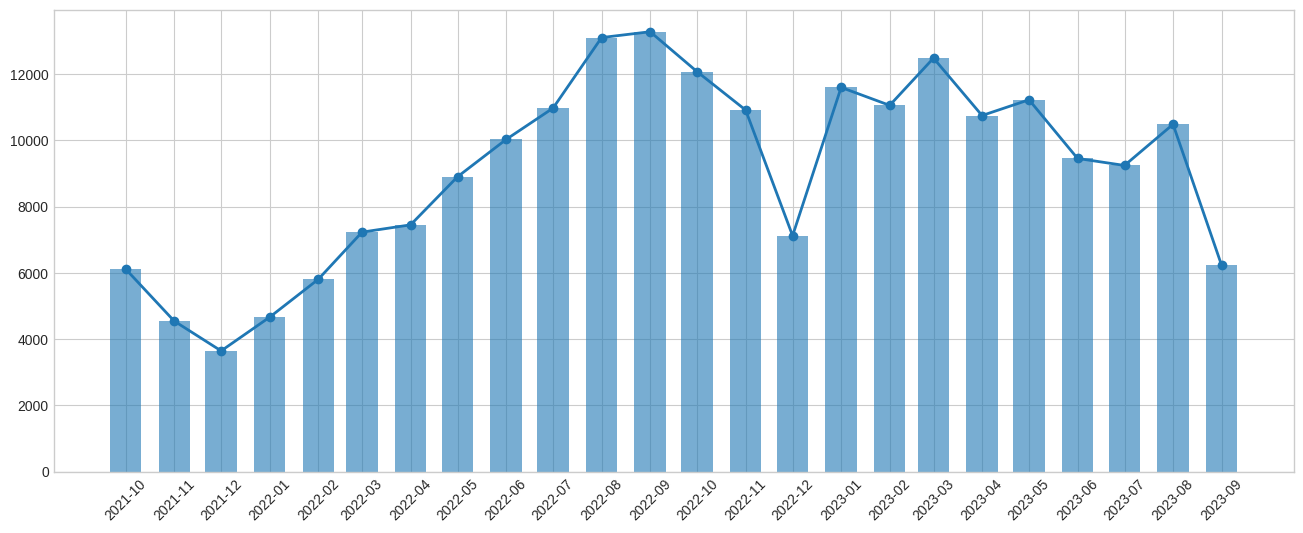

In [40]:
# Monthly aggregation on the updated df_cut
monthly = (
    df_cut
    .set_index('published_at_first')
    .resample('MS')
    .size()
    .rename('count')
    .asfreq('MS', fill_value=0)
)
fig, ax = plt.subplots(figsize=(16,6))

bars = ax.bar(monthly.index, monthly.values, width=20, alpha=0.6)

ax.plot(monthly.index, monthly.values, linewidth=2.0, marker='o')

ax.set_xticks(monthly.index)
ax.set_xticklabels([d.strftime('%Y-%m') for d in monthly.index], rotation=45)

plt.show()


In [41]:
Markdown(f'''The end of 2021, from October to December, showed a decrease in posted job offers. A similar situation occurred from September 2022.<br>
Also in September 2023, a decline in posted offers began to appear, likely due to the last quarter of the year.
            Upward trends start from January and took various forms. In 2022, the upward trend continued until September.<br>
            In 2023, the upward trend starting in January began from a higher level and was not as linear as in 2022. Between January and May it fluctuated. Then it declined from June, except for August.<br>
            Such a low number of offers in December 2021 may have been caused by a drop in demand for specialists after the 2020 pandemic.
''')

The end of 2021, from October to December, showed a decrease in posted job offers. A similar situation occurred from September 2022.<br>
Also in September 2023, a decline in posted offers began to appear, likely due to the last quarter of the year.
            Upward trends start from January and took various forms. In 2022, the upward trend continued until September.<br>
            In 2023, the upward trend starting in January began from a higher level and was not as linear as in 2022. Between January and May it fluctuated. Then it declined from June, except for August.<br>
            Such a low number of offers in December 2021 may have been caused by a drop in demand for specialists after the 2020 pandemic.


In [42]:
# Extract year and month
df_cut['year'] = df_cut['published_at_first'].dt.year
df_cut['month'] = df_cut['published_at_first'].dt.month

# Group by year and month and count job offers
monthly_by_year = df_cut.groupby(['year', 'month']).size().reset_index(name='count')

# Remove months where the number of offers = 0
monthly_by_year = monthly_by_year[monthly_by_year['count'] > 0].copy()

# Month names in English
month_labels_en = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_by_year['Month_name'] = monthly_by_year['month'].apply(lambda x: month_labels_en[x-1])

# Sorting
monthly_by_year = monthly_by_year.sort_values(['year','month']).reset_index(drop=True)

# Display
# monthly_by_year


#### 3.1.4 Number of offers by month

In [43]:
# Extract month from the date
df_cut['month'] = df_cut['published_at_first'].dt.month

# Group by months and count the number of offers
monthly_total = df_cut.groupby('month').size()

# Optionally, add month names in English
months_labels_en = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_total.index = months_labels_en

# Display results
print(monthly_total)


Jan    16259
Feb    16858
Mar    19708
Apr    18196
May    20122
Jun    19476
Jul    20212
Aug    23581
Sep    19505
Oct    18186
Nov    15459
Dec    10767
dtype: int64


The highest number of job postings occurs from March to October. After that, we observe a decline in offers.

#### 3.1.5 Insights from the analysis of publication times

📌 Key insights (lifetime < 180 days)

- The average duration of a job offer is around 25 days, and 75% of postings close before day 35 – a realistic, stable IT recruitment cycle.

- The mean lifetime is 35.8 days, slightly higher than the median, indicating that after removing outliers, the distribution is much more normal and representative.

- The standard deviation dropped to 27.9 days, confirming that the filtered data are less dispersed and more reliable.

- The shortest offers last 1 day, suggesting rapid closures for certain roles (e.g., popular positions or quick-hire recruitments).

- The largest segment of offers closes within 0–35 days, confirming that a typical IT recruitment lasts about a month and is a relatively fast process.

- Recruitments lasting 36–60 days make up a noticeable portion of the market, suggesting a stable group of roles requiring more time (e.g., niche technologies, more demanding qualifications, or multi-step processes).

- The 61–90 days range covers another, smaller but significant segment of offers, indicating more challenging recruitments or longer durations due to operational reasons (e.g., decision delays, longer selection processes).

- Offers active for 91–120 days are above-standard recruitments, potentially reflecting issues with offer attractiveness, unusual requirements, limited candidate availability, or process inconsistencies.

- Offers over 120 days are not exceptional but represent a small group — long-open or low-converting postings that require special attention (e.g., improving content, salary ranges, tech stack, or requirements).

- Seasonality: the number of offers declines at the end of the year (October–December), highest in the first half of the year.

- Early-year growth: upward trend from January to May/June each year.

- Differences between years: 2022 – stable and linear growth; 2023 – higher start, greater variability.

- Most active months: May and August; fewest offers in December and November.

- Pandemic effect: December 2021 had a low number of offers, likely following declines in 2020–2021.

## 3.2 Column 'remote'

In [44]:
# # # # # # # # # # # # # # #
# ---Helper functions ---
# # # # # # # # # # # # # # #

#--- describe ---
def describe_column_distribution(df, column_name, title=None):
    """
    Automatically generates a readable markdown describing:
    - the number of records
    - the count of each unique value
    - the percentage of each value (sorted descending)
    - the number of unique values
    """
    total = len(df)
    value_counts = df[column_name].value_counts()
    value_percents = (value_counts / total * 100).round(2)
    unique_values = df[column_name].nunique()

    if title is None:
        title = f"Column analysis **{column_name}**"

    md = f"### {title}\n"
    # md += f"Number of records: **{total}**\n\n"
    md += f"Number of unique values: **{unique_values}**\n\n"
    # md += "#### Value distribution:\n"

    for value, count in value_counts.items():
        percent = value_percents[value]
        md += f"- **{value}**: {count} ({percent}%)\n"

    display(Markdown(md))
    return None   # <<< ADDED



def get_order_and_colors(df, column):
    # Set the order from the smallest to the largest category
    order = df[column].value_counts().sort_values().index.tolist()

    # Set a color palette (one for the entire analysis)
    colors = sns.color_palette("tab10", len(order)).as_hex()

    # Dictionary: category → color
    color_map = dict(zip(order, colors))
    return order, color_map


# --- Proportion plot ----

def plot_proportion_distribution(df, column, title=None):
    # Global order and colors
    order, color_map = get_order_and_colors(df, column)

    # Data preparation
    job_type_counts = df[column].value_counts().loc[order].reset_index()
    job_type_counts.columns = [column, 'Number of offers']

    # Plot
    fig = px.bar(
        job_type_counts,
        x=column,
        y='Number of offers',
        text='Number of offers',
        title=title,
        color=column,
        color_discrete_map=color_map
    )
    fig.update_layout(width=900, height=550, showlegend=False)
    fig.update_traces(textposition='outside')
    fig.show()



# --- monthly plot ---

def plot_monthly_category_counts(df, date_col, category_col, title=None):
    df = df.copy()
    df['month_start'] = df[date_col].values.astype('datetime64[M]')

    # global order and colors
    order, color_map = get_order_and_colors(df, category_col)

    # grouping
    monthly = df.groupby(['month_start', category_col], observed=False).size().unstack(fill_value=0)

    # arrange columns in a consistent order
    monthly = monthly[order]

    # plot
    fig, ax = plt.subplots(figsize=(16,6))
    monthly.plot(
        kind='bar',
        ax=ax,
        width=0.8,
        alpha=0.75,
        color=[color_map[c] for c in order]
    )

    if title is None:
        title = f'Number of offers per month by: {category_col}'

    ax.set_xlabel('Month', fontsize=13)
    ax.set_ylabel('Number of records', fontsize=13)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=12)
    ax.set_xticklabels([d.strftime('%b %Y') for d in monthly.index], rotation=45, ha='right')

    ax.grid(True, alpha=0.25, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(title=category_col)

    plt.tight_layout()
    plt.show()
    

#--- monthly category summary ---
def monthly_category_summary(df, date_col, category_col, show_style=True):
    df = df.copy()

    # Year and month
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    
    # Grouping
    monthly = df.groupby(['year', 'month', category_col]).size().unstack(fill_value=0).reset_index()
    # monthly = df.groupby([date_col, category_col], observed=False).size().unstack(fill_value=0)

    # All categories
    categories = (
        df[category_col]
        .value_counts()
        .sort_values()       # from smallest to largest
        .index
        .tolist()
    )

    # Create missing columns
    for cat in categories:
        if cat not in monthly.columns:
            monthly[cat] = 0

    # Total
    monthly['Total'] = monthly[categories].sum(axis=1)

    # Percentages
    for cat in categories:
        monthly[f'% {cat}'] = (monthly[cat] / monthly['Total'] * 100).round(2)

    # Month labels in English
    month_labels_en = ['Jan','Feb','Mar','Apr','May','Jun',
                       'Jul','Aug','Sep','Oct','Nov','Dec']
    monthly['Month'] = monthly['month'].apply(lambda x: month_labels_en[x-1])

    # Filter and sort
    monthly = monthly[monthly['Total'] > 0]
    monthly = monthly.sort_values(['year', 'month']).reset_index(drop=True)

    # Column order
    ordered_cols = ['year', 'Month']
    for cat in categories:
        ordered_cols += [cat, f'% {cat}']
    ordered_cols += ['Total']
    result = monthly[ordered_cols]

    # --- Styling ---
    if show_style:
        # automatically generate colors
        colors = sns.color_palette("tab10", len(categories)).as_hex()

        styler = result.style
        
        for cat, color in zip(categories, colors):
            styler = styler.bar(subset=[f'% {cat}'], color=color + "80")  # 80 = semi-transparent

        return styler

    return result

In [45]:
# # # # # # # # # # # # # # #
# --- Helper functions for multiple categories in a column ---
# # # # # # # # # # # # # # #

#--- description for selected categories in a column ---
def describe_categories(df, tech_columns):
    """
    Shows for selected technologies:
    - how many records contain the technology
    - percentage of records relative to total
    """
    total = len(df)
    md = f"### Analysis of selected technologies\n"
    md += f"Number of records in the dataset: **{total}**\n\n"

    for tech in tech_columns:
        if tech in df.columns:
            count = df[tech].sum() if df[tech].dtype in ['int64','float64','bool'] else df[tech].astype(bool).sum()
            percent = (count / total * 100).round(2)
            md += f"- **{tech}**: {count} ({percent}%)\n"
        else:
            md += f"- **{tech}**: column not present in DataFrame\n"

    display(Markdown(md))
    return None

def describe_marker_categories(df, cat_list, column='marker_icon'):
    """
    Shows for selected technologies in the `marker_icon` column:
    - how many records contain the technology
    - percentage of records relative to total
    """
    total = len(df)
    md = f"### Analysis of selected technologies in the `{column}` column\n"
    md += f"Number of records in the dataset: **{total}**\n\n"

    for tech in cat_list:
        count = df[column].str.contains(tech, case=False, na=False).sum()
        percent = (count / total * 100).round(2)
        md += f"- **{tech}**: {count} ({percent}%)\n"

    display(Markdown(md))
    return None

# --- proportion plot for selected categories ---
def plot_selected_categories(df, column='marker_icon', selected=None, title=None, palette='tab10'):
    """
    Bar chart showing only selected technologies from the `column`.
    Categories are ordered from the smallest to the largest number of records.
    """
    if selected is None:
        selected = ['javascript', 'java', 'data', 'python']

    # Filter df to selected technologies
    df_filtered = df[df[column].isin(selected)]

    # Count and sort
    counts = df_filtered[column].value_counts()
    order = counts.sort_values().index.tolist()  # from smallest to largest

    # Color mapping
    colors = sns.color_palette(palette, n_colors=len(order)).as_hex()
    color_map = dict(zip(order, colors))

    # Prepare data
    tech_counts = counts.loc[order].reset_index()
    tech_counts.columns = [column, 'Number of offers']

    # Plot
    fig = px.bar(
        tech_counts,
        x=column,
        y='Number of offers',
        text='Number of offers',
        title=title,
        color=column,
        color_discrete_map=color_map
    )
    fig.update_layout(width=900, height=550, showlegend=False)
    fig.update_traces(textposition='outside')
    fig.show()


# --- monthly distribution plot only for selected categories ---
def plot_monthly_selected_categories(df, date_col, category_col, selected=None, title=None, palette='tab10'):
    """
    Bar chart showing only selected categories split by months.
    Categories are ordered from the smallest to largest number of records.
    """

    df = df.copy()
    df['month_start'] = df[date_col].values.astype('datetime64[M]')

    if selected is None:
        selected = ['javascript','java','data','python']

    # Filter df to selected categories
    df_filtered = df[df[category_col].isin(selected)]

    # Count total records per category (global) and set order
    counts = df_filtered[category_col].value_counts().sort_values()  # from smallest to largest
    order = counts.index.tolist()

    # Colors
    colors = sns.color_palette(palette, n_colors=len(order)).as_hex()
    color_map = dict(zip(order, colors))

    # Monthly grouping
    monthly = df_filtered.groupby(['month_start', category_col]).size().unstack(fill_value=0)

    # Arrange columns in set order
    monthly = monthly[order]

    # Plot
    fig, ax = plt.subplots(figsize=(16,6))
    monthly.plot(
        kind='bar',
        ax=ax,
        width=0.8,
        alpha=0.75,
        color=[color_map[c] for c in order]
    )

    if title is None:
        title = f'Number of offers per month by: {category_col}'

    ax.set_xlabel('Month', fontsize=13)
    ax.set_ylabel('Number of offers', fontsize=13)
    ax.set_title(title, fontsize=16, fontweight='bold', pad=12)
    ax.set_xticklabels([d.strftime('%b %Y') for d in monthly.index], rotation=45, ha='right')

    ax.grid(True, alpha=0.25, axis='y')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(title=category_col)

    plt.tight_layout()
    plt.show()

# --- monthly summary for selected categories ---
def monthly_category_summary_selected(df, date_col, category_col, selected=None, show_style=True):
    """
    Monthly summary for selected categories in a column.
    Shows counts, percentages, and optionally visualizes using DataFrame.style.
    """

    df = df.copy()

    # Year and month
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month

    # Filter to selected values if provided
    if selected is not None:
        df = df[df[category_col].isin(selected)]

    # Grouping
    monthly = df.groupby(['year', 'month', category_col]).size().unstack(fill_value=0).reset_index()

    # All categories in df
    categories = (
        df[category_col]
        .value_counts()
        .sort_values()       # from smallest to largest
        .index
        .tolist()
    )

    # Create missing columns
    for cat in categories:
        if cat not in monthly.columns:
            monthly[cat] = 0

    # Total
    monthly['Total'] = monthly[categories].sum(axis=1)

    # Percentages
    for cat in categories:
        monthly[f'% {cat}'] = (monthly[cat] / monthly['Total'] * 100).round(2)

    # Month labels in English
    month_labels_en = ['Jan','Feb','Mar','Apr','May','Jun',
                       'Jul','Aug','Sep','Oct','Nov','Dec']
    monthly['Month'] = monthly['month'].apply(lambda x: month_labels_en[x-1])

    # Filter and sort
    monthly = monthly[monthly['Total'] > 0]
    monthly = monthly.sort_values(['year', 'month']).reset_index(drop=True)

    # Column order
    ordered_cols = ['year', 'Month']
    for cat in categories:
        ordered_cols += [cat, f'% {cat}']
    ordered_cols += ['Total']
    result = monthly[ordered_cols]

    # --- Styling ---
    if show_style:
        colors = sns.color_palette("tab10", len(categories)).as_hex()
        styler = result.style
        for cat, color in zip(categories, colors):
            styler = styler.bar(subset=[f'% {cat}'], color=color + "80")
        return styler

    return result

In [46]:
describe_column_distribution(
    df_cut, 
    'remote', 
    title="Column 'remote' contains the following values:"
)

### Column 'remote' contains the following values:
Number of unique values: **2**

- **Remote**: 162727 (74.53%)
- **On-site**: 55602 (25.47%)


In [47]:
plot_proportion_distribution(
    df_cut, 
    'remote', 
    title="Number of job offers by the 'remote' column"
)


In [48]:
amount_of_records = len(df_cut)
remote = (df_cut['remote'] == 'Remote').sum()
office = (df_cut['remote'] == 'On-site').sum()
Markdown(f"### The dominant job type is remote work {remote} ({remote*100/amount_of_records:.2f}%), followed by on-site work {office} ({office*100/amount_of_records:.2f}%)")

### The dominant job type is remote work 162727 (74.53%), followed by on-site work 55602 (25.47%)

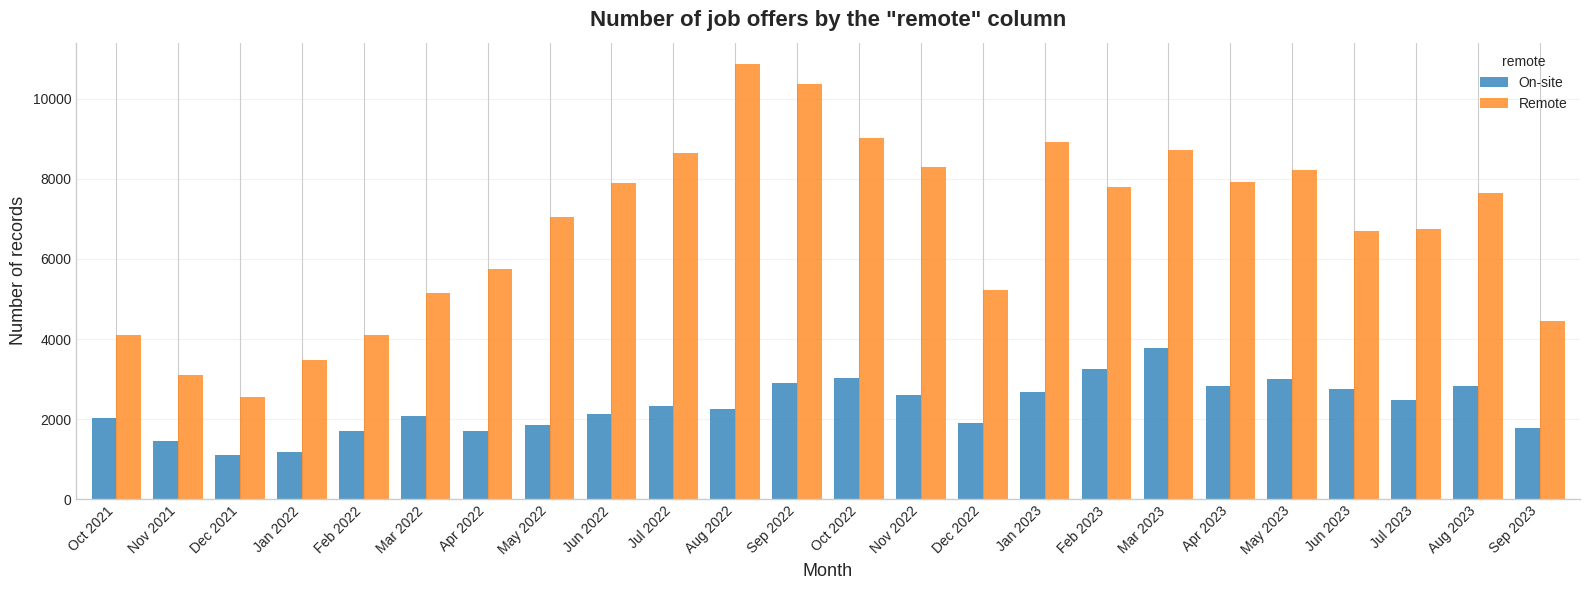

In [49]:
plot_monthly_category_counts(
    df_cut,
    date_col='published_at_first',
    category_col='remote',
    title='Number of job offers by the "remote" column'
)

In [50]:
monthly_category_summary(
    df_cut,
    date_col='published_at_first',
    category_col='remote'
)

#### Insights from the analysis of the "remote" column

- Considering that there is a 'remote_interview' column, the data probably also relates to remote recruitment.

- The "remote" column most likely describes the remote form of recruitment. The increase in job offers in individual months was mainly driven by postings with a recruitment process conducted remotely — these shaped the overall trend.

- In 2021–2022, remote recruitment became the standard and was used by most companies, and its high share persisted in 2023. On-site recruitments were more stable and changed mainly seasonally.

- The beginning of 2023, however, shows a slight increase in on-site recruitment, which may be the result of some companies gradually moving away from the "remote-first" model.

## 3.3 Column "workplace_type"

In [51]:
describe_column_distribution(df_cut, 'workplace_type', title="The 'workplace_type' column contains categories:")

### The 'workplace_type' column contains categories:
Number of unique values: **3**

- **remote**: 162727 (74.53%)
- **partly_remote**: 49070 (22.48%)
- **office**: 6532 (2.99%)


In [52]:
plot_proportion_distribution(df_cut, 'workplace_type', title='The number of offers by "workplace type"')

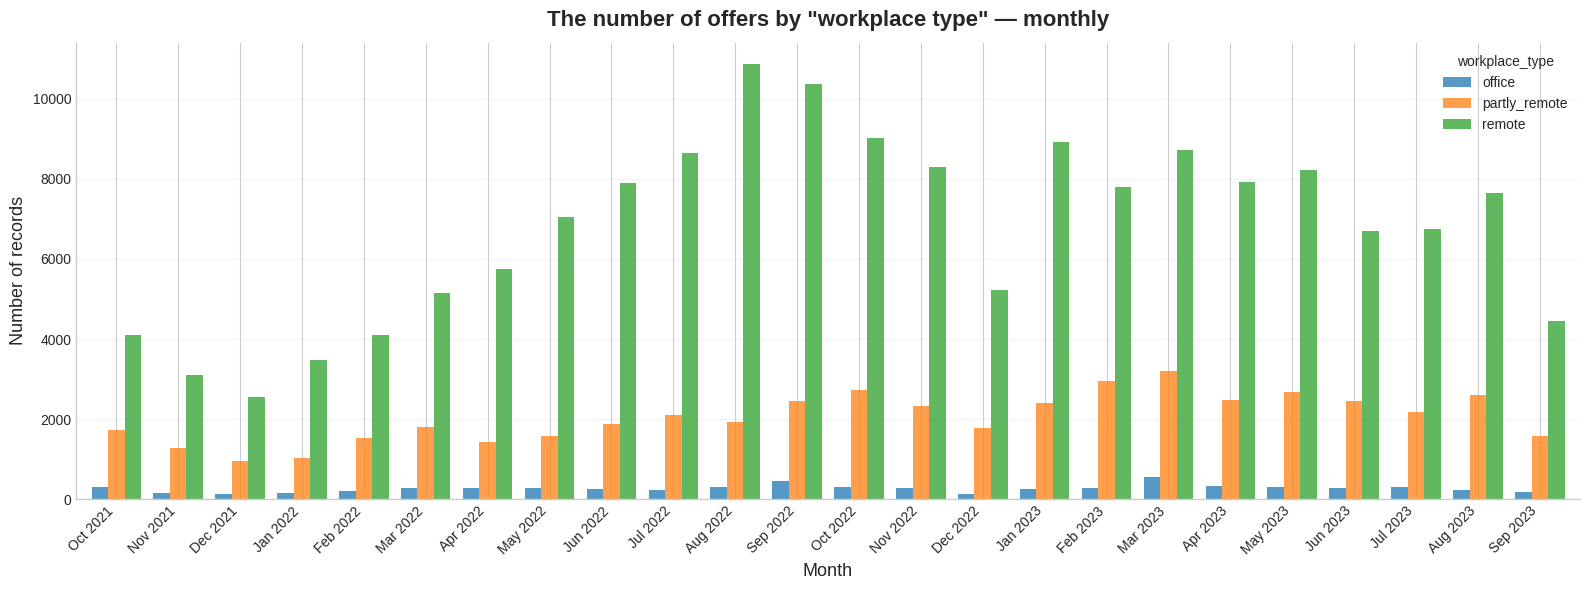

In [53]:
plot_monthly_category_counts(
    df_cut,
    date_col='published_at_first',
    category_col='workplace_type',
    title='The number of offers by "workplace type" — monthly'
)

In [54]:
monthly_category_summary(
    df_cut,
    date_col='published_at_first',
    category_col='workplace_type'
)

## 3.4 Column "open_to_hire_ukrainians"

In [55]:
describe_column_distribution(df_cut, 'open_to_hire_ukrainians', title="The 'open_to_hire_ukrainians' column contains categories:")

### The 'open_to_hire_ukrainians' column contains categories:
Number of unique values: **3**

- **Does not matter**: 127505 (58.4%)
- **Open to Ukrainians**: 66337 (30.38%)
- **Unknown**: 24487 (11.22%)


In [56]:
plot_proportion_distribution(df_cut, 'open_to_hire_ukrainians', title='Number of offers open to Ukrainians')

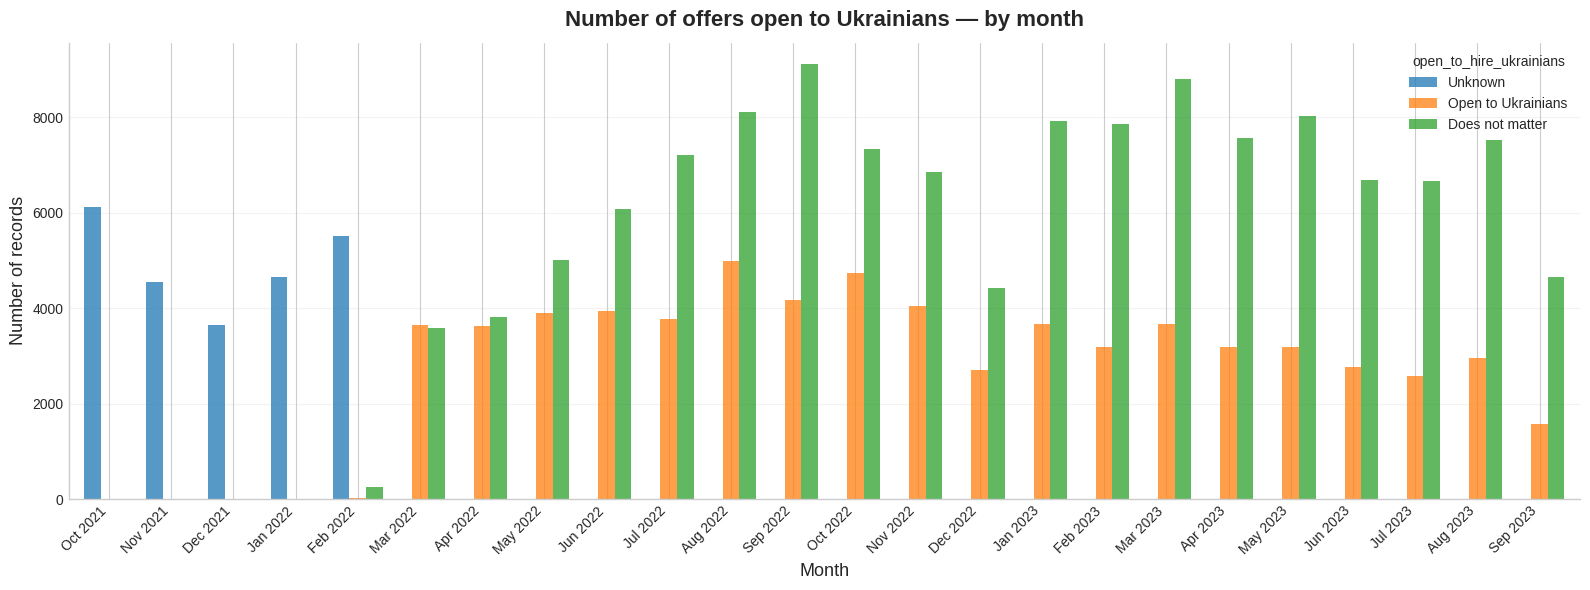

In [57]:
plot_monthly_category_counts(
    df_cut,
    date_col='published_at_first',
    category_col='open_to_hire_ukrainians',
    title='Number of offers open to Ukrainians — by month'
)

In [58]:
monthly_category_summary(
    df_cut,
    date_col='published_at_first',
    category_col='open_to_hire_ukrainians'
)

## 3.5 Column "remote_interview"

In [59]:
describe_column_distribution(df_cut, 'remote_interview', title="The categories column 'remote_interview' contains categories:")

### The categories column 'remote_interview' contains categories:
Number of unique values: **2**

- **Remote interview**: 167153 (76.56%)
- **On-site interview**: 51176 (23.44%)


In [60]:
plot_proportion_distribution(df_cut, 'remote_interview', title='Number of offers by Recruitment Type')

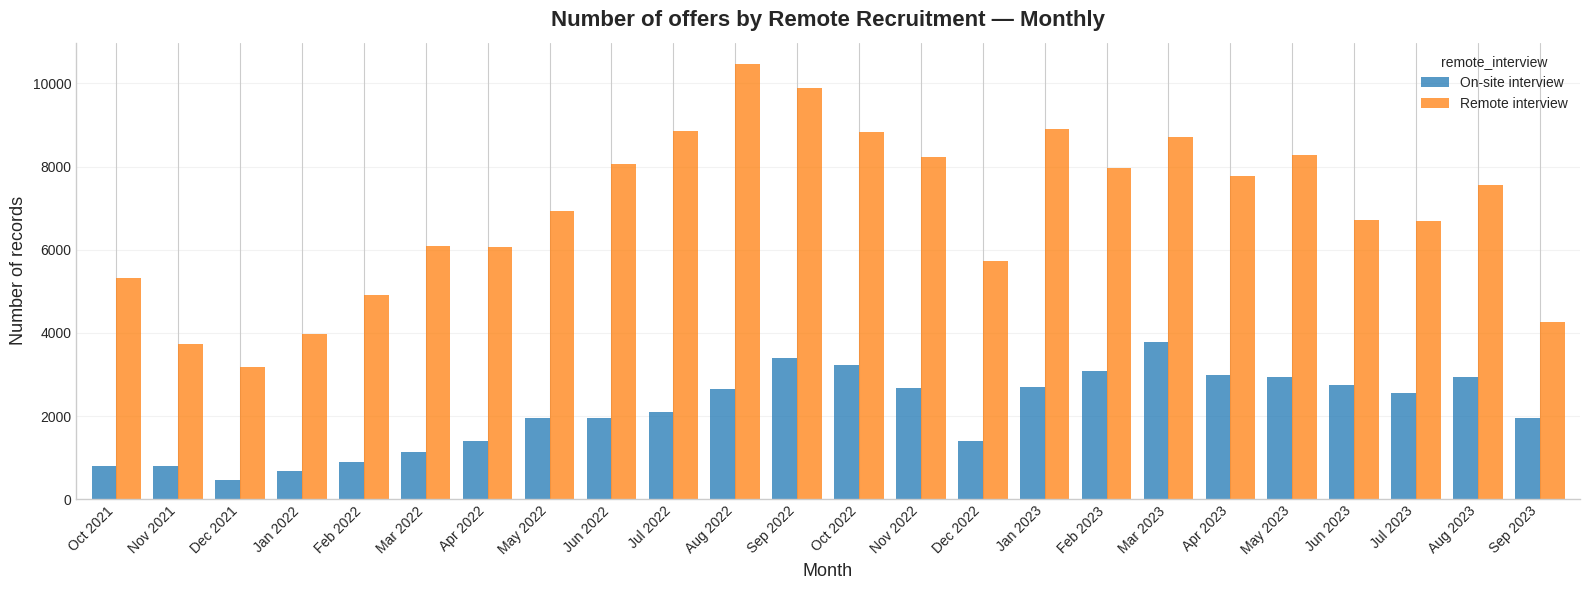

In [61]:
plot_monthly_category_counts(
    df_cut,
    date_col='published_at_first',
    category_col='remote_interview',
    title='Number of offers by Remote Recruitment — Monthly'
)

In [62]:
monthly_category_summary(
    df_cut,
    date_col='published_at_first',
    category_col='remote_interview'
)

#### Conclusions from the analysis of the "remote_interview" column

- General overview (number and proportion of records) is similar to the "remote" column.

The overall trend may resemble the situation observed in the ratio of Remote vs. On-site Work, but it is not identical.

The proportion of offers with remote recruitment has been steadily increasing since the end of 2021 (October - December). In May 2022, we see a noticeable increase compared to previous months. In Q3 2022, there is a visible decrease in both on-site and remote offers, followed by a rebound. This may suggest companies attempting to return to on-site work and placing greater importance on in-person meetings.

## 3.6 Column "type" (contract type)

In [63]:
describe_column_distribution(df_cut, 'type', title="The 'type' column contains categories:")

### The 'type' column contains categories:
Number of unique values: **3**

- **b2b**: 134323 (61.52%)
- **permanent**: 81086 (37.14%)
- **mandate_contract**: 2920 (1.34%)


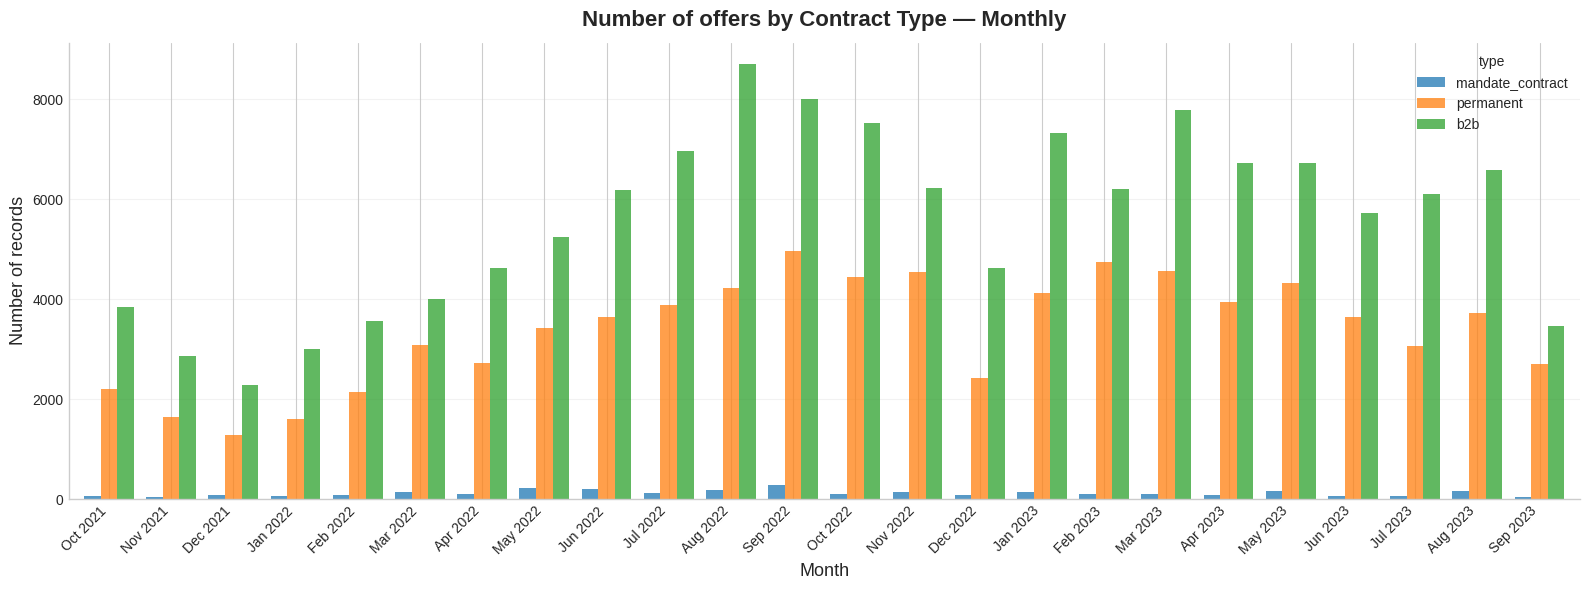

In [64]:
plot_monthly_category_counts(
    df_cut,
    date_col='published_at_first',
    category_col='type',
    title='Number of offers by Contract Type — Monthly'
)

In [65]:
monthly_category_summary(
    df_cut,
    date_col='published_at_first',
    category_col='type'
)

#### Conclusions from the analysis of the "type" column (contract type)

The distribution of offers clearly shows seasonal trends. Q3 exhibits a decrease in offers.

B2B remains the dominant contract type (55–66%), although its share slightly decreases in 2023. Permanent contracts are gaining strength, especially at the beginning of 2023 (up to ~43%), indicating more stable employment. Mandate_contract is a marginal category (<3%). Seasonally, there are drops in offers in December and slight fluctuations during the summer, while the rest of the year remains stable.


In [66]:
# info_df_cut = pd.DataFrame({
#     'Column': df_cut.columns,
#     "Duplicates": df_cut.duplicated().sum(),
#     'Non-null': df_cut.notnull().sum().values,
#     'Missing values': df_cut.isna().sum().values,
#     'Percentage of missing values': (df_cut.isna().sum()*100/df_cut.notnull().sum()).values,
#     'Unique values': df_cut.nunique().values,
#     'Data type': df_cut.dtypes.values,
# })

# info_df_cut


## 3.7 Column "Marker icon"

In [67]:
describe_column_distribution(df_cut, 'marker_icon', title="The 'marker_icon' column contains categories:")

### The 'marker_icon' column contains categories:
Number of unique values: **24**

- **javascript**: 28957 (13.26%)
- **java**: 22825 (10.45%)
- **testing**: 15221 (6.97%)
- **net**: 15170 (6.95%)
- **devops**: 14850 (6.8%)
- **data**: 13725 (6.29%)
- **pm**: 11104 (5.09%)
- **python**: 10804 (4.95%)
- **php**: 9808 (4.49%)
- **admin**: 9115 (4.17%)
- **mobile**: 8473 (3.88%)
- **analytics**: 8245 (3.78%)
- **support**: 7801 (3.57%)
- **other**: 7508 (3.44%)
- **architecture**: 6966 (3.19%)
- **c**: 6538 (2.99%)
- **erp**: 4917 (2.25%)
- **security**: 4429 (2.03%)
- **ux**: 4157 (1.9%)
- **ruby**: 2291 (1.05%)
- **go**: 1711 (0.78%)
- **game**: 1572 (0.72%)
- **html**: 1321 (0.61%)
- **scala**: 821 (0.38%)


#### We can assume these are the most sought-after technologies or skills

In [68]:
plot_proportion_distribution(df_cut, 'marker_icon', title='Number of offers by "Main Technologies (icon)"')

In [69]:
categories = ['javascript', 'java', 'data', 'python']
describe_marker_categories(df_cut, categories)

### Analysis of selected technologies in the `marker_icon` column
Number of records in the dataset: **218329**

- **javascript**: 28957 (13.26%)
- **java**: 51782 (23.72%)
- **data**: 13725 (6.29%)
- **python**: 10804 (4.95%)


In [70]:
plot_selected_categories(df_cut, column='marker_icon', 
                           selected=['javascript','java','data','python'],
                           title='Selected "Main Technologies (icon)" in offers')


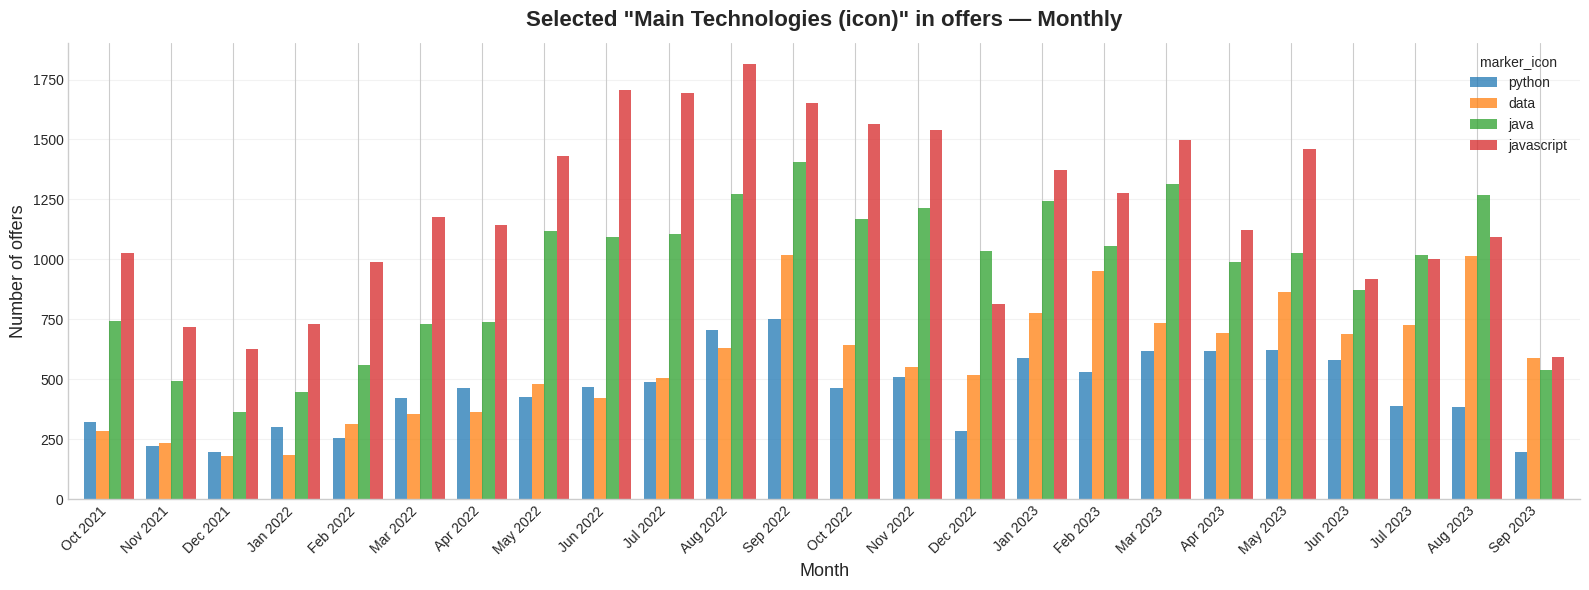

In [71]:
plot_monthly_selected_categories(
    df_cut,
    date_col='published_at_first',
    category_col='marker_icon',
    selected=['javascript','java','data','python'],
    title='Selected "Main Technologies (icon)" in offers — Monthly'
)


In [72]:
monthly_category_summary_selected(
    df_cut,
    date_col='published_at_first',
    category_col='marker_icon',
    selected=['javascript','java','data','python']
)


### Conclusions for the 'Python' technology:
#### Year 2021

- The number of offers ranged from ~197 to 322 per month.

- The percentage share of Python offers ranged between 12–14%.

- There is a decrease in the number of offers towards the end of the year – a declining trend in Q4.

#### Year 2022

- The number of offers in most months was higher than in 2021, e.g., March 420, September 1017.

- The percentage share of Python offers increased in selected months (up to ~21% in September).

- The trend was uneven and seasonal, with noticeable spikes in certain months, especially during the summer and in September.

#### Year 2023

- The number of offers was generally higher than in previous years (e.g., January 777, August 1015).

- The percentage share of Python offers was also higher (up to ~31% in September).

- There were large fluctuations between months – growth was not linear but followed a seasonal trend with variations.

#### Overall observation

- Compared to 2021 and 2022, the average number of Python offers in 2023 was higher.

- The increase was not uniform – seasonal spikes and monthly fluctuations were observed.

- The annual trend shows that Python was becoming increasingly popular, but no stable, consistent monthly growth was observed.

#### Conclusions for 'Python'

- The biggest increase in interest in Python occurred in 2022, where the number of offers grew almost continuously from January to September — this was the most dynamic period for this technology.

- The year 2023 started very strong, with a high share of Python offers (14–19%), but after June there was a noticeable decline in both the number of offers and the percentage shares.

- The end of the years (October–December 2021, 2022, and September 2023) brings the fewest Python offers, which aligns with the overall decrease in total job postings in Q4.

### Conclusions for 'Data Work' (data):

- In 2023, the number of offers related to data work was generally higher than in 2022, e.g., in February it increased to 952 offers (24.97%), and in September it reached the highest share of 30.75%.

- The trend showed seasonal fluctuations, with a higher number of offers in Q2 and Q3, while drops occurred in some months between July and September.

- The percentage share of "Data" offers in the total number of offers gradually increased throughout the year, indicating growing interest in data-related work in job postings.

### Conclusions for the 'Java' technology

- In 2023, the number of Java offers varied across months – the highest values were recorded in January (1243 offers, 31.22%) and August (1268 offers, 33.71%), while in September the number dropped to 540 offers (28.14%).

- Compared to 2022, the percentage share of Java offers in the total number of offers remained relatively stable, mainly fluctuating between 25–34%.

- The overall trend showed seasonal fluctuations, without a clear systematic increase or decrease, although short peaks appeared, e.g., in May–August 2022 and January–August 2023.

### Conclusions for the 'JavaScript' technology

- The number of offers in 2023 was lower than in most months of 2022, indicating a general decline in interest in JavaScript job postings during the analyzed period.

- The percentage share of JavaScript offers also gradually decreased – in January 2023 it was 34.46%, and by September it dropped to 30.90%, whereas in peak months of 2022 (e.g., June – 46.25%) it was significantly higher.

- Seasonal fluctuations are visible – the lowest percentage values were recorded in June and August 2023 (30–31%), with short rebounds in March and May 2023 (35–36%).

- Overall, it can be concluded that in 2023 the JavaScript job market lost share compared to the previous year, even though short-term increases occurred in some months.

## 3.8 Column "skills"

## 3.8.1 General overvie of column "skills"

In [73]:
# Snippet defining individual technologies from the 'skills' column

amount_of_records = len(df_cut)

all_skills = df_cut['skills'].dropna().apply(lambda x: [s.strip() for s in x.split(',')])

flat_skills = [skill for sublist in all_skills for skill in sublist]

skill_counts = Counter(flat_skills)

Markdown(f'#### There are {len(skill_counts)} different required skills and technologies in offers with specified salaries')

#### There are 10592 different required skills and technologies in offers with specified salaries

There are 10592 different required skills and technologies


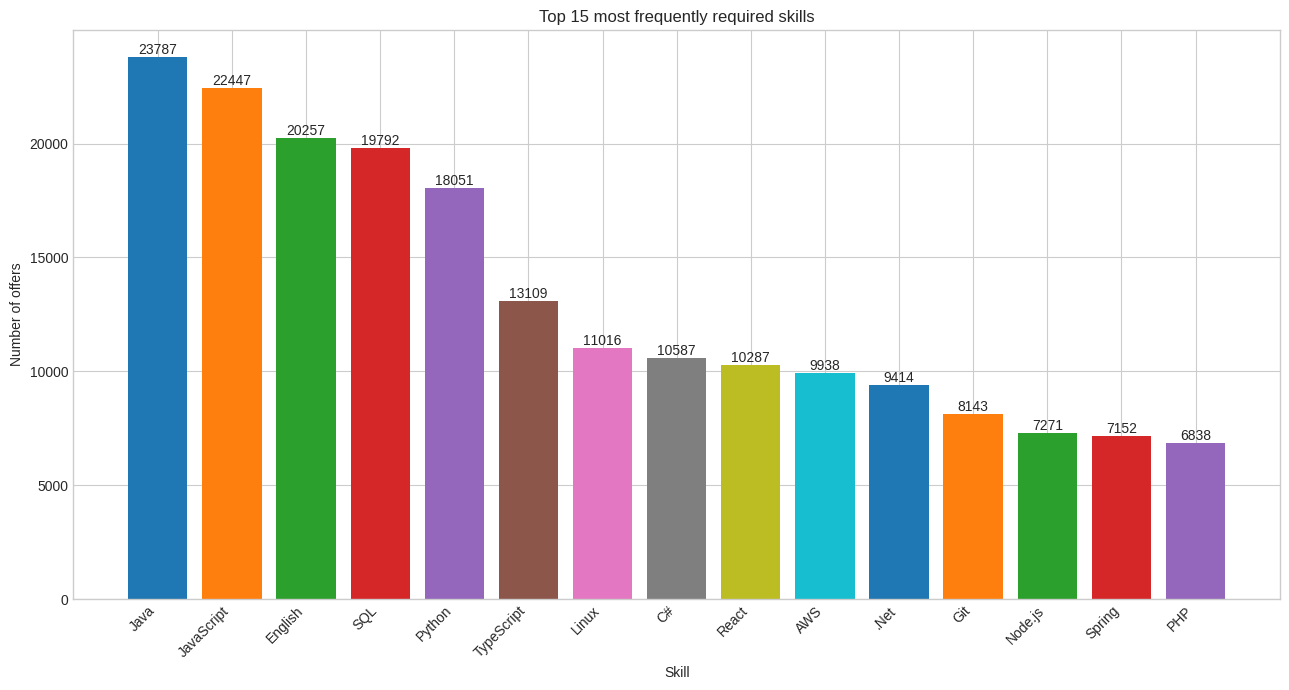

In [74]:
# Flatten the list of lists into a single list
flat_skills = [skill for sublist in all_skills for skill in sublist]

skill_counts = Counter(flat_skills)

print(f"There are {len(skill_counts)} different required skills and technologies")

skills_df = (
    pd.DataFrame(skill_counts.items(), columns=['skills', 'Number of offers'])
      .sort_values(by='Number of offers', ascending=False)
)

top_n = 15
top_df = skills_df.head(top_n)

# Colors using tab10
colors = plt.cm.tab10.colors

plt.figure(figsize=(13, 7))

bars = plt.bar(
    top_df['skills'],
    top_df['Number of offers'],
    color=colors[:top_n if top_n <= 10 else 10]  # tab10 has only 10 colors
)

# Adding values above bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title(f"Top {top_n} most frequently required skills")
plt.xlabel("Skill")
plt.ylabel("Number of offers")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

#### The direct distribution of technologies from the 'skills' column differs from 'marker_icon', which is more general.

The "Java" language takes the first place, followed by "JavaScript" in second. The "Python" language ranks fourth (after "English" if we assume English is not a technology). This gives a completely different picture of technology requirements.

## 3.8.2 Examination of the 4 most popular technologies: Java, JavaScript, SQL, and Python

In [75]:
# If 'skills' is a string containing a list of skills
# make sure everything is lowercase
df_cut['skills_str'] = df_cut['skills'].astype(str).str.lower()

# 1. marker_icon = javascript 
js_marker_java_skill = df_cut[
    (df_cut['marker_icon'].str.lower() == 'javascript') &
    (df_cut['skills_str'].str.contains(r'\bjava\b'))
]

js_marker_python_skill = df_cut[
    (df_cut['marker_icon'].str.lower() == 'javascript') &
    (df_cut['skills_str'].str.contains(r'\bpython\b'))
]

# 2. marker_icon = java
java_marker_js_skill = df_cut[
    (df_cut['marker_icon'].str.lower() == 'java') &
    (df_cut['skills_str'].str.contains(r'\bjavascript\b'))
]

java_marker_python_skill = df_cut[
    (df_cut['marker_icon'].str.lower() == 'java') &
    (df_cut['skills_str'].str.contains(r'\bpython\b'))
]

# 3. marker_icon = data
data_marker_python_skill = df_cut[
    (df_cut['marker_icon'].str.lower() == 'data') &
    (df_cut['skills_str'].str.contains(r'\bpython\b'))
]

data_marker_sql_skill = df_cut[
    (df_cut['marker_icon'].str.lower() == 'data') &
    (df_cut['skills_str'].str.contains(r'\bsql\b'))
]

print(f'There are {len(js_marker_java_skill)} offers labeled as JavaScript that also require Java')
print(f'There are {len(js_marker_python_skill)} offers labeled as JavaScript that also require Python')
print(f'There are {len(java_marker_js_skill)} offers labeled as Java that also require JavaScript')
print(f'There are {len(java_marker_python_skill)} offers labeled as Java that also require Python')
print(f'There are {len(data_marker_python_skill)} offers labeled as Data that also require Python')
print(f'There are {len(data_marker_sql_skill)} offers labeled as Data that also require SQL')



There are 715 offers labeled as JavaScript that also require Java
There are 357 offers labeled as JavaScript that also require Python
There are 1098 offers labeled as Java that also require JavaScript
There are 478 offers labeled as Java that also require Python
There are 3882 offers labeled as Data that also require Python
There are 6575 offers labeled as Data that also require SQL


In [76]:
def describe_skills_distribution(df, skills_column="skills",
                                 tracked_skills=None, title="Distribution of selected technologies in the 'skills' column"):
    """
    Analysis of technologies in the 'skills' column, which is a string.
    Counts how many times each technology appears in the job postings.
    """

    if tracked_skills is None:
        tracked_skills = ["Java", "JavaScript", "SQL", "Python"]

    total = len(df)

    # initialize dictionary
    counts = {skill: 0 for skill in tracked_skills}

    # counting
    for raw in df[skills_column].fillna(""):
        text = raw.lower()
        for skill in tracked_skills:
            if skill.lower() in text:
                counts[skill] += 1

    # calculate percentages
    percents = {skill: round(counts[skill] / total * 100, 2) for skill in tracked_skills}

    # Markdown
    md = f"### {title}\n"
    md += f"Number of records: **{total}**\n\n"

    for skill in tracked_skills:
        md += f"- **{skill}**: {counts[skill]} ({percents[skill]}%)\n"

    display(Markdown(md))


In [77]:
def plot_monthly_skill_counts(df):
    df = df.copy()

    # Data → month
    df['month_start'] = df['published_at_first'].values.astype('datetime64[M]')

    # Technologies to track
    tracked = ["Java", "JavaScript", "SQL", "Python"]

    # Function to check the presence of a technology in the skills string
    def has_skill(skills_string, skill):
        if pd.isna(skills_string):
            return False
        return skill.lower() in skills_string.lower()

    # Create 0/1 columns for each technology
    for skill in tracked:
        df[skill] = df['skills'].apply(lambda x: has_skill(x, skill))

    # Monthly grouping
    monthly = df.groupby('month_start')[tracked].sum()

    # Colors (fixed and readable)
    colors = {
        "Java": "#1f77b4",        # tab10[0]
        "JavaScript": "#ff7f0e",  # tab10[1]
        "SQL": "#2ca02c",         # tab10[2]
        "Python": "#d62728"       # tab10[3]
    }

    # Plot
    fig, ax = plt.subplots(figsize=(16,6))

    monthly.plot(
        kind='bar',
        ax=ax,
        width=0.85,
        alpha=0.85,
        color=[colors[s] for s in tracked]
    )

    ax.set_title("Monthly number of offers vs selected technologies in the 'skills' column",
                 fontsize=16, fontweight='bold', pad=12)
    ax.set_xlabel("Month")
    ax.set_ylabel("Number of offers")

    ax.set_xticklabels(
        [d.strftime('%b %Y') for d in monthly.index],
        rotation=45, ha='right'
    )

    ax.grid(axis='y', alpha=0.25)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.legend(title="Technology")
    plt.tight_layout()
    plt.show()


In [78]:
describe_skills_distribution(df_cut,
                             tracked_skills=["Java", "JavaScript", "SQL", "Python"])


### Distribution of selected technologies in the 'skills' column
Number of records: **218329**

- **Java**: 50002 (22.9%)
- **JavaScript**: 23246 (10.65%)
- **SQL**: 32218 (14.76%)
- **Python**: 19611 (8.98%)


In [79]:
def plot_skills_distribution(
    df,
    skills_column="skills",
    tracked_skills=None,
    title="Distribution of technologies in the 'skills' column"
):
    
    # Default technologies
    if tracked_skills is None:
        tracked_skills = ["Java", "JavaScript", "SQL", "Python"]

    # Counting occurrences
    counts = {skill: 0 for skill in tracked_skills}

    for val in df[skills_column].fillna(""):
        text = val.lower()
        for skill in tracked_skills:
            if skill.lower() in text:
                counts[skill] += 1

    # Convert to DataFrame
    df_counts = (
        pd.DataFrame.from_dict(counts, orient='index', columns=['Number of offers'])
          .reset_index()
          .rename(columns={'index': 'Technology'})
    )

    # Get order and colors from your function
    order, color_map = get_order_and_colors(
        df_counts.rename(columns={"Technology": skills_column}),
        skills_column
    )

    # Set order
    df_counts["Technology"] = pd.Categorical(df_counts["Technology"], categories=order, ordered=True)
    df_counts = df_counts.sort_values("Technology")

    # Plot
    fig = px.bar(
        df_counts,
        x="Technology",
        y="Number of offers",
        text="Number of offers",
        title=title,
        color="Technology",
        color_discrete_map=color_map,
    )

    fig.update_layout(width=900, height=550, showlegend=False)
    fig.update_traces(textposition='outside')
    fig.show()


In [80]:
def monthly_skills_summary(
    df,
    date_col="published_at_first",
    skills_col="skills",
    tracked_skills=None,
    show_style=True
):
    df = df.copy()

    # Default technologies
    if tracked_skills is None:
        tracked_skills = ["Java", "JavaScript", "SQL", "Python"]

    # Ensure date is datetime
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

    # Year and month
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month

    # Prepare binary columns (1 if contains the technology)
    for skill in tracked_skills:
        df[skill] = df[skills_col].str.contains(skill, case=False, na=False).astype(int)

    # Monthly grouping
    monthly = df.groupby(['year', 'month'])[tracked_skills].sum().reset_index()

    # Monthly total
    monthly['Total'] = monthly[tracked_skills].sum(axis=1)

    # Percentages
    for skill in tracked_skills:
        monthly[f'% {skill}'] = (monthly[skill] / monthly['Total'] * 100).round(2)

    # Month abbreviations EN
    month_labels_en = ['Jan','Feb','Mar','Apr','May','Jun',
                       'Jul','Aug','Sep','Oct','Nov','Dec']
    monthly['Month'] = monthly['month'].apply(lambda x: month_labels_en[x-1])

    # Remove months with no data
    monthly = monthly[monthly['Total'] > 0]
    monthly = monthly.sort_values(['year', 'month']).reset_index(drop=True)

    # Column order
    ordered_cols = ['year', 'Month']
    for skill in tracked_skills:
        ordered_cols += [skill, f'% {skill}']
    ordered_cols += ['Total']

    result = monthly[ordered_cols]

    # STYLING
    if show_style:
        colors = sns.color_palette("tab10", len(tracked_skills)).as_hex()
        styler = result.style

        for skill, color in zip(tracked_skills, colors):
            styler = styler.bar(subset=[f'% {skill}'], color=color + "80")

        return styler

    return result




In [81]:
plot_skills_distribution(
    df_cut,
    tracked_skills=["Java", "JavaScript", "SQL", "Python"]
)


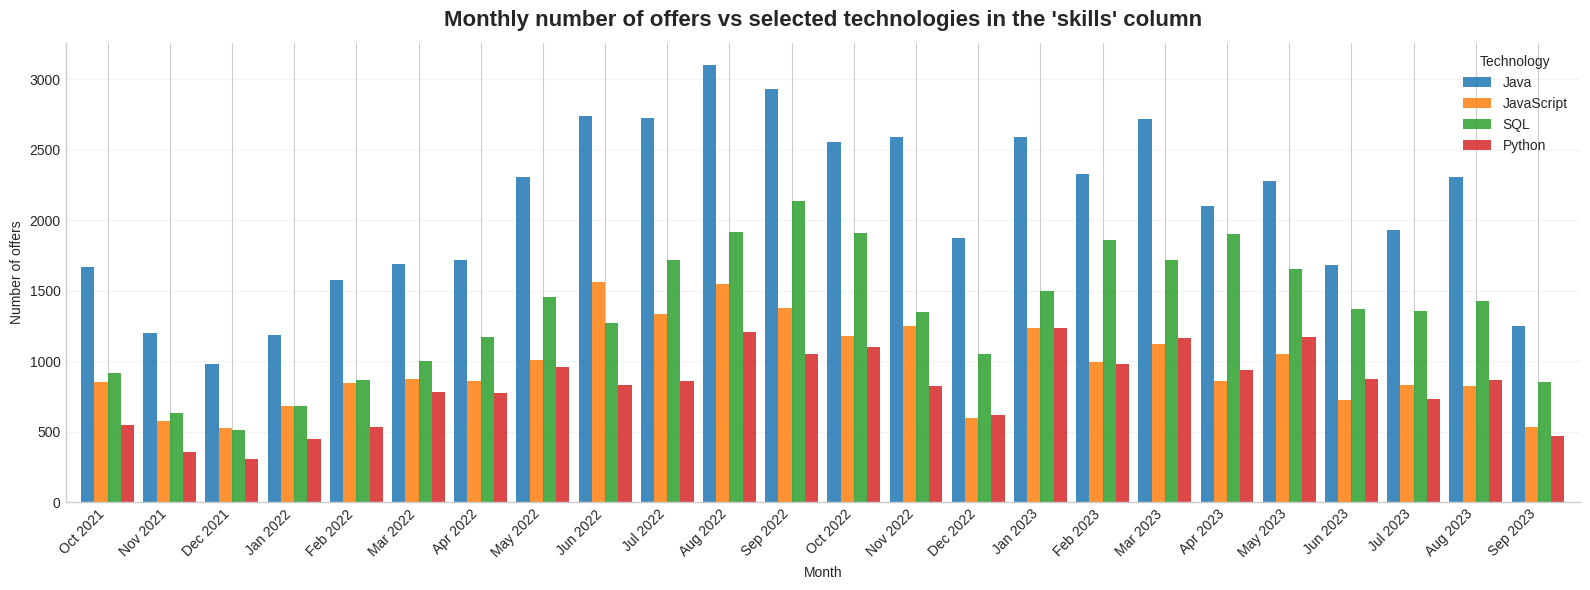

In [82]:
plot_monthly_skill_counts(df_cut)

In [83]:
monthly_skills_summary(
    df_cut,
    tracked_skills=["Java", "JavaScript", "SQL", "Python"]
)


#### Conclusions from the analysis of the 4 most frequently required technologies:

#### Java

- Java remained the most frequently required language in job offers throughout the period.

- Dips occurred in February and April 2023 (share ~36–37%), possibly due to seasonal recruitment slowdowns in some projects or budget shifts.

- Peaks were observed at the end of 2022, e.g., December 2022 (~45% share), suggesting increased demand at year-end or completion of projects requiring Java.

- Java remained a key technology, with short declines likely related to project cycles rather than reduced demand.

#### JavaScript

- JavaScript gradually lost share in job offers compared to Java and SQL.

- Dips in 2023 (e.g., April 2023 ~15%, September 2023 ~17%) indicate a decline in its prominence in offers in the first half of the year.

- Peaks occurred in mid-2022 (~24%), possibly due to larger frontend or web projects during that period.

- Conclusion: JavaScript remained important, but its share decreased over time, which may reflect a shift of projects toward backend development and data analytics.

#### SQL

- SQL gradually increased its share in job offers, from ~22% in 2021 to ~27–32% in selected months of 2023.

- Peaks appeared in March 2022, September 2022, and April 2023 (~25–32%), indicating growing demand for data analytics and databases in projects.

- Dips in June 2022 (~20%) were likely due to seasonality.

- Conclusion: SQL became an increasingly important skill, especially in analytical and data processing projects, confirming the growing significance of data in companies.

#### Python

- Python remained relatively stable, with a share of ~12–19%.

- Peaks in March and May 2022 (~17–18%) and May and June 2023 (~18–19%) indicate periodic increased demand for data analysts and data engineers.

- Dips in December 2021 (~13%) and September 2023 (~15%) show minimal fluctuations, without dramatic changes.

- Python was consistently present in job offers, largely in data-related projects, but its share did not dominate the market.


### Conclusions from the analysis of technologies in the *marker_icon* and *skills* columns

Python, Java, JavaScript, and SQL/Data consistently ranked among the most frequently mentioned technologies. Differences appeared in the details – in the marker_icon analysis, representing the main technology in the offer, Python ranked only 7th, whereas in the skills analysis, which includes all skills listed in the posting, it was 4th (excluding English, which is not a technology).  

This shows that Python appeared more often in skill sets than as the main “marker” of the offer, suggesting it was an important supplementary skill but less frequently the dominant technology. In contrast, Java and JavaScript were relatively stable at the top in both analyses, while SQL/Data showed similar trends, although its percentage share in skills was slightly higher than in marker_icon.  

In summary: overall trends were consistent, but skills provides a fuller picture of the technologies in job offers, while marker_icon more clearly indicates the dominant technology.

## 3.9 Columna 'experience_level'

In [84]:
describe_column_distribution(df_cut, 'experience_level', title="The 'experience_level' column contains categories:")

### The 'experience_level' column contains categories:
Number of unique values: **3**

- **mid**: 115853 (53.06%)
- **senior**: 86158 (39.46%)
- **junior**: 16318 (7.47%)


In [85]:
plot_proportion_distribution(df_cut, 'experience_level', title='Number of offers by Experience Level')

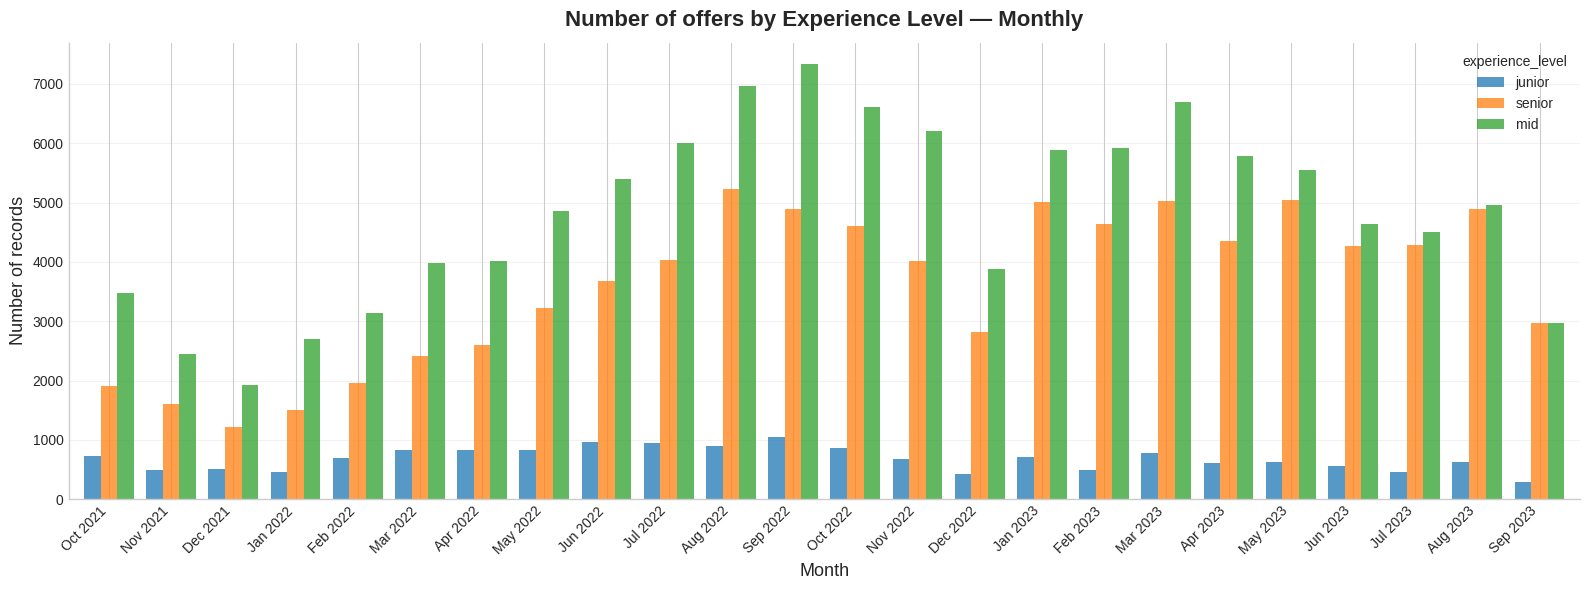

In [86]:
plot_monthly_category_counts(
    df_cut,
    date_col='published_at_first',
    category_col='experience_level',
    title='Number of offers by Experience Level — Monthly'
)

The share of juniors in the market remained consistently low, and its fluctuations did not significantly deviate from the overall trend in the number of offers.  
We observe a slight upward trend in 2022, followed by a decline in 2023.

As offers dominated by mids and seniors increased, the percentage of juniors decreased, since the market demand was mainly driven by mid- and senior-level positions.

In [87]:
monthly_category_summary(
    df_cut,
    date_col='published_at_first',
    category_col='experience_level'
)

#### Conclusions for 'experience level'

- The job market clearly shifted towards more experienced specialists.

- Juniors represented an increasingly smaller portion of offers. Month by month, their share gradually declined, and overall demand for this experience level weakened. Throughout the analyzed period, the trend for juniors was distinctly downward.

- Mids maintained a dominant position most of the time. Their share was stable, though it slightly decreased toward the end of the period. They still formed a large and necessary group, but their advantage over seniors gradually diminished.

- Seniors became increasingly sought after. Their share steadily grew and was the main beneficiary of the decline in other groups' shares. Companies increasingly directed their expectations towards more experienced candidates, which was evident in a long-term, stable upward trend.

- In summary, the market increasingly favored specialists with more experience, the share of juniors clearly declined, mids remained important but slightly shrinking, and seniors gradually assumed a dominant position.

# 3.10 Columna "company_size"

### 3.10.1 General view of column "comapny_size"

The "company_size" column contains 302 unique values, so ranges need to be created.

In [88]:
bins = [0, 10, 50, 200, 500, 1000, 5000, 10000, float('inf')]
labels = [
    "1–10", "11–50", "51–200", "201–500",
    "501–1000", "1001–5000", "5001–10000", "10000+"
]

df_cut['company_size_bins'] = pd.cut(
    df_cut['company_size'],
    bins=bins,
    labels=labels,
    right=True,
    include_lowest=True
)

In [89]:
describe_column_distribution(df_cut, 'company_size_bins', title="The 'company_size_bins' column contains categories:")

### The 'company_size_bins' column contains categories:
Number of unique values: **8**

- **51–200**: 57218 (26.21%)
- **11–50**: 46373 (21.24%)
- **201–500**: 35730 (16.37%)
- **501–1000**: 27431 (12.56%)
- **1001–5000**: 25204 (11.54%)
- **10000+**: 9678 (4.43%)
- **5001–10000**: 8867 (4.06%)
- **1–10**: 7727 (3.54%)


In [90]:
plot_proportion_distribution(df_cut, 'company_size_bins', title='Number of offers by Company Size')

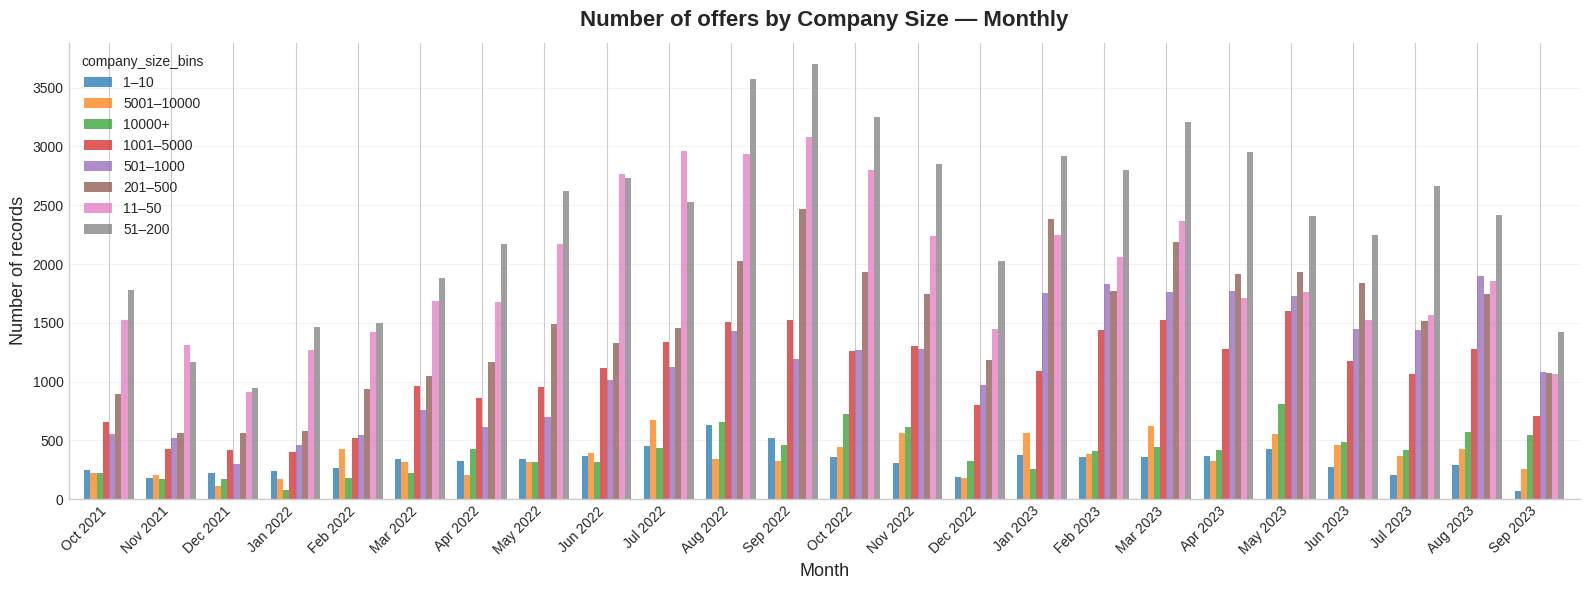

In [91]:
plot_monthly_category_counts(
    df_cut,
    date_col='published_at_first',
    category_col='company_size_bins',
    title='Number of offers by Company Size — Monthly'
)

In [92]:
monthly_category_summary(
    df_cut,
    date_col='published_at_first',
    category_col='company_size_bins'
)

/tmp/ipykernel_14376/2939959719.py:125: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



#### Wnioski z analizy wielkości firm

1. Dominują dwie grupy firm: 11–50 i 51–200

- W każdym miesiącu najwięcej ofert pochodziło z firm 11–50 i 51–200 pracowników.
- Razem zajmowały 45–55% całego rynku, co wskazuje na dominację średnich firm i scale-upów.
- Trend był stabilny: przez cały okres te dwie grupy były fundamentem rynku pracy.

2. Największe firmy (10001+) rosły, ale pozostawały niszowe

- Udział firm 10000+ zwykle wynosił 3–7%, ze szczytami:
- 2022 październik–listopad (ok. 6%)
- 2023 maj–wrzesień (7–9%)
- W 2023 ich udział zauważalnie wzrósł — sygnał stabilizacji zatrudnień w korporacjach po pandemicznych cięciach.

3. Spółki 1001–5000 oraz 501–1000 wyraźnie zwiększyły aktywność w 2023

- Grupa 1001–5000 osiągała:
- 10–13% w 2021–2022
- aż 15–18% w 2023
- To jeden z największych trendów wzrostowych — firmy duże, ale nie korporacyjne, odbudowały rekrutację najszybciej.

4. Mikrofirmy (1–10) pozostawały marginalne

- Ich udział wynosił 2–5%, stosunkowo stabilnie.
- Mikroprzedsiębiorstwa nie były znaczącym źródłem ogłoszeń — rynek napędzały większe podmioty.

5. Najbardziej chaotyczne i sezonowe były firmy 201–500

- W 2021–2022 ich udział oscylował: 8–16%
- W 2023 spadł do 15–18%, ale z częstymi skokami.
- To przedział z wyraźną sezonowością i reaktywnością na sytuację rynkową.

6. Najważniejsze trendy 2021 → 2023

✔ Firmy średnie (11–50, 51–200)
- Stabilne, największy udział w każdym roku
- Utrzymują pozycję bez większych spadków

✔ Duże firmy (501–1000, 1001–5000)

Wyraźny wzrost znaczenia w 2023

- Przejęły część udziału od firm najmniejszych i korporacji

✔ Giganci (10000+)

- Wzrost udziału w 2023, ale pozostają niszowi
- Ich aktywność jest falowa, reaguje na globalne wydarzenia (cięcia, hiring freeze)

✔ Mikrofirmy (1–10)

- Udział minimalny, praktycznie bez zmian
- Nie wpływają istotnie na rynek

7. Najważniejsze obserwacje biznesowe

- Rynek pracy IT w latach 2021–2023 był zdominowany przez średnie firmy, nie przez korporacje ani startupy.
- W 2023 zwiększyła się aktywność firm 500–5000 pracowników — sygnał stabilizacji i powrotu inwestycji.
- Największe firmy (10000+) zwiększały liczbę ofert, ale wciąż stanowiły niszową część rynku.
- Trendy wskazują na przesuwanie się rynku od startupów → ku większym, stabilnym organizacjom.

#### Podsumowanie wniosków:
W każdej obserwacji dominują firmy małe (11–50 i 51–200), razem zwykle 40–55% wszystkich rekordów.

Firmy średnie (201–500, 501–1000) trzymają stabilny udział 20–30%, z lekkim spadkiem po połowie 2023 r.

Duże firmy (1001–5000, 5001–10000, 10000+) mają niski, ale dość stabilny udział — zwykle 10–20%.

Ogólny trend: im większa firma, tym bardziej stabilne, ale mniejsze wolumeny; główne wahania napędzają segmenty 11–50 i 51–200.

### 3.10.2 Zbadanie jakich rozmiarów firmy najczęściej oferują prace dla juniorów

In [93]:
# Odfiltrowanie
df_jun = df_cut[df_cut['experience_level'] == 'junior']

# bins = [0, 10, 50, 200, 500, 1000, 5000, 10000, float('inf')]
# labels = ["1–10", "11–50", "51–200", "201–500",
#           "501–1000", "1001–5000", "5001–10000", "10000+"]

# df_jun["company_size_bins"] = pd.cut(df_jun["company_size"], bins=bins, labels=labels)

In [94]:
describe_column_distribution(df_jun, 'company_size_bins', title="Kategorie kolumny 'company_size_bins' tylko dla juniorów zawiera kategorie:")

### Kategorie kolumny 'company_size_bins' tylko dla juniorów zawiera kategorie:
Number of unique values: **8**

- **51–200**: 4258 (26.09%)
- **11–50**: 4210 (25.8%)
- **201–500**: 2801 (17.17%)
- **501–1000**: 1597 (9.79%)
- **1001–5000**: 1321 (8.1%)
- **1–10**: 716 (4.39%)
- **10000+**: 707 (4.33%)
- **5001–10000**: 699 (4.28%)


In [95]:
plot_proportion_distribution(df_jun, 'company_size_bins', title='Liczba ofert wg Wielkości przedsiębiorstwa')

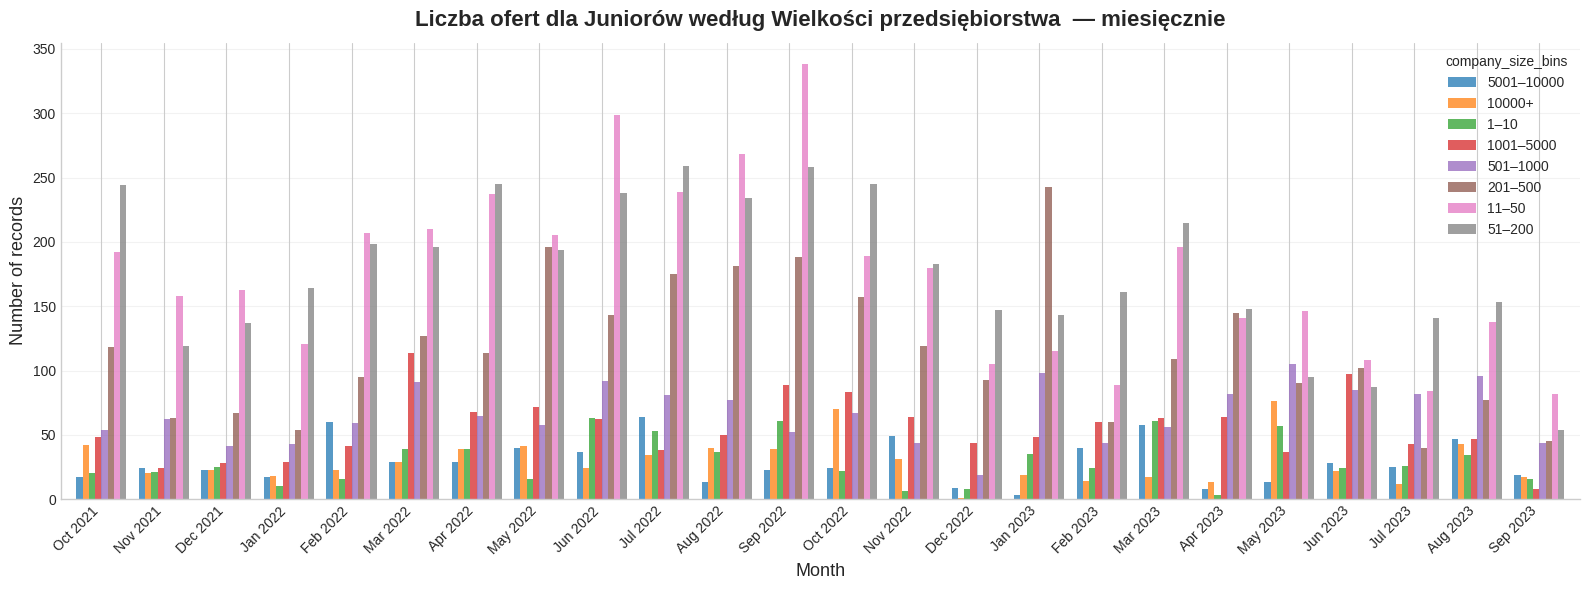

In [96]:
plot_monthly_category_counts(
    df_jun,
    date_col='published_at_first',
    category_col='company_size_bins',
    title='Liczba ofert dla Juniorów według Wielkości przedsiębiorstwa  — miesięcznie'
)

In [97]:
monthly_category_summary(
    df_jun,
    date_col='published_at_first',
    category_col='company_size_bins'
)

/tmp/ipykernel_14376/2939959719.py:125: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



### Conclusions for Company Size

1. Dominance of Small and Medium-Sized Companies

- Most offers for juniors came from companies with 11–50 and 51–200 employees — in many months they exceeded 40–50% of all offers.

2. Micro-Companies and Large Corporations

- Micro-companies (1–10) and huge corporations (10000+) had a very low share (<5%), suggesting that juniors were mainly recruited by SMEs.

3. Seasonal Fluctuations

- The highest number of offers for juniors in the 11–50 and 51–200 bins occurred in Q2 and Q3 of 2022, followed by declines in 2023.
- The largest drops affected the biggest companies (10000+) and large-medium firms (5001–10000) — in many months their share was marginal.

4. Medium-Large Companies (1001–5000) Were Stable but Not Dominant

- Their share was around 10–15%, with the highest values in March and April 2023.
- This indicates that medium-large organizations actively recruited juniors, but not as intensively as SMEs.

5. Overall Trend 2021–2023

- 2022 was the peak year in terms of junior offers.
- In 2023, a decline in the number of offers is visible across most bins, especially in the largest companies, but SMEs still accounted for the majority of junior recruitment.


Juniors were primarily recruited by small and medium-sized companies (11–200 employees), which accounted for the majority of offers each month. In the largest corporations (5001+ employees) and micro-companies (1–10), the share of offers was marginal, and in 2023 there was an overall decline in the number of offers regardless of the organization size.

# 3.11 Financial Columns


For the purpose of analyzing salaries in the industry:

- A new DataFrame will be created containing only positions with salary ranges.

- Only salaries in PLN will be analyzed.

- Suspicious records will be removed.

- A "mean_salary" column will be created, containing the average value between "salary_from" and "salary_to".

- Everything will be analyzed for the three experience levels: "junior", "mid", and "senior".

In [98]:
salary_df = df_cut[
    (df_cut['salary_from'] > 0) &
    (df_cut['salary_to'] > 0)
].copy()

print(f'Numer of records with salary: {len(salary_df)}')

Numer of records with salary: 150497


In [99]:
describe_column_distribution(salary_df, 'salary_currency', title="The 'salary_currency' column contains the following categories:")

### The 'salary_currency' column contains the following categories:
Number of unique values: **5**

- **pln**: 136672 (90.81%)
- **eur**: 7372 (4.9%)
- **usd**: 5675 (3.77%)
- **gbp**: 684 (0.45%)
- **chf**: 94 (0.06%)


In [100]:
small_salaries = salary_df[salary_df['salary_from'] < 1000]
# small_salaries
print(f'There are {len(small_salaries)} ({len(small_salaries)*100/len(salary_df):.2f}%) records with suspiciously low salaries that do not correspond to monthly wages.')

There are 30 (0.02%) records with suspiciously low salaries that do not correspond to monthly wages.


#### Removal of suspicious records and offers with foreign currency.

In [101]:
salary_df = salary_df[salary_df['salary_from'] >= 1000]
salary_df = salary_df[salary_df['salary_currency'] == 'pln']

#### Creation of the 'salary_mean' column

In [102]:
salary_df['salary_mean'] = ((salary_df['salary_from'] + salary_df['salary_to']) / 2).round(0).astype(int)

#### Examination of outlier values


In [103]:


Q1 = salary_df['salary_mean'].quantile(0.25)
Q3 = salary_df['salary_mean'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = salary_df[(salary_df['salary_mean'] < lower_bound) | (salary_df['salary_mean'] > upper_bound)]

display(Markdown(f'We have **{len(outliers)}** outlier values, which is {len(outliers)/len(salary_df)*100:.2f}% of the entire dataset.<br>They can be removed'))

We have **1254** outlier values, which is 0.92% of the entire dataset.<br>They can be removed

In [104]:
salary_df = salary_df[
    (salary_df['salary_mean'] >= lower_bound) &
    (salary_df['salary_mean'] <= upper_bound)
].reset_index(drop=True)

In [105]:
fig = px.box(
    salary_df,
    x='workplace_type',
    y='salary_mean',
    color='workplace_type',
    facet_col='experience_level',
    title='Salary distribution by job type and employment type, split by experience level',
    points='all'
)

fig.update_layout(
    width=1200,
    height=600,
    showlegend=False
)

fig.show()

#### Analysis of the chart: Salary distribution by job type and employment type

1. Seniors

- Remote and partly-remote pay almost the same — medians are very close (around 22–25k).
- Office clearly pays more — medians ~26–28k with much higher upper ranges.
- Conclusion: Seniors in the office earn more than fully remote, contrary to expectations — but this is because office offers in the data generally represent the "highest paying" positions.

2. Mid-level

- Remote and partly-remote again almost identical: medians ~15–17k.
- Office again higher — medians ~18–20k.
- Conclusion: Same effect as above — office > the rest.

3. Juniors

- Remote ~7–9k (highest),
- Partly-remote ~7–8k,
- Office ~6–7k (lowest).

The only level where remote actually pays best.

#### Summary of trends

- Remote and partly-remote are practically identical → analyzing them separately is not necessary.

- Office paid more for mid/senior levels, showing that at that time there was no reversal of the trend favoring higher compensation for remote work.

- Juniors earn best in fully remote positions, which makes sense because remote juniors are typically sought in IT rather than by large corporations.

# Step 4. Correlation Matrix

## 4.1 Clasic Pearson's correlation

In [106]:
corr_matrix = salary_df.select_dtypes(include=['number']).corr()

corr_matrix

company_size  salary_from  salary_to  lifetime_in_days  \
company_size          1.000000     0.053266   0.062903         -0.015490   
salary_from           0.053266     1.000000   0.915517         -0.035822   
salary_to             0.062903     0.915517   1.000000         -0.007262   
lifetime_in_days     -0.015490    -0.035822  -0.007262          1.000000   
year                  0.072236     0.170228   0.155374         -0.143166   
month                -0.004427    -0.018362  -0.018966          0.000058   
salary_mean           0.059748     0.974951   0.982059         -0.020807   

                      year     month  salary_mean  
company_size      0.072236 -0.004427     0.059748  
salary_from       0.170228 -0.018362     0.974951  
salary_to         0.155374 -0.018966     0.982059  
lifetime_in_days -0.143166  0.000058    -0.020807  
year              1.000000 -0.520518     0.165703  
month            -0.520518  1.000000    -0.019093  
salary_mean       0.165703 -0.019093     1.000000

In [107]:
corr_matrix = salary_df.select_dtypes(include=['number']).corr()

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title= 'Correlation Matrix - salary_df',
    width=1200,
    height=900
)
fig.update_layout(font=dict(size=12))
fig.show()

### Conclusions:

- The strongest positive correlations are observed among the salary-related variables: "salary_from", "salary_to", and "salary_mean" (0.91–0.98). This indicates that a higher minimum salary goes hand in hand with a higher maximum and average salary, which is intuitive.

- The remaining variables show weak linear correlations (close to zero), indicating no clear linear relationships between them in this view.

The Pearson correlation matrix primarily shows linear dependencies between numerical variables, particularly strong relationships among "Salary From", "Salary To", and "Mean Salary". Correlations for categorical variables that were assigned numerical values should be interpreted with caution — Pearson only measures linear relationships between numbers and does not reflect the actual relationships between categories. Therefore, conclusions regarding categorical variables may not correspond to reality.

### 5.3 Using Categorical Variable Correlations with **Cramér's V**

#### Cramér’s V Matrix

Value range:

0 → no association

0–0.3 → weak association

0.3–0.5 → moderate association

0.5 → strong association

Values above 0.6–0.7 may cause Cramér’s V to appear inflated, suggesting a strong correlation even though in practice the association may not be that significant.

In [108]:
from scipy.stats import chi2_contingency

# 🔥 Funkcja Cramér's V
def cramers_v(x, y):
    cm = pd.crosstab(x, y)
    chi2 = chi2_contingency(cm)[0]
    n = cm.sum().sum()
    return np.sqrt(chi2 / (n * (min(cm.shape) - 1)))

# 🔥 Lista wszystkich kolumn kategorycznych
categorical_cols = [
    'city', 'country_code', 'marker_icon', 'workplace_type',
    'company_size', 'experience_level', 'remote_interview',
    'company_size_bins', 'type', 'open_to_hire_ukrainians'
]

# Tworzymy pustą macierz
cramers_matrix = pd.DataFrame(
    index=categorical_cols,
    columns=categorical_cols,
    dtype=float
)

# Wypełniamy macierz
for col1 in categorical_cols:
    for col2 in categorical_cols:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0
        else:
            cramers_matrix.loc[col1, col2] = cramers_v(salary_df[col1], salary_df[col2])

# Wyświetlamy gradientem
cramers_matrix.style.background_gradient(cmap="coolwarm", vmin=0, vmax=1)



#### Conclusions from the **Cramér's V** correlation analysis

1. Company size vs. employment type and recruitment

- The analysis showed that company size was associated with employment type (company_size – type ≈ 0.35).
- Larger companies offered various forms of employment (permanent contracts, B2B, mandates), while smaller companies more often used a single type of contract.

The relationship between company size and remote interviews (company_size – remote_interview ≈ 0.30) indicated that larger companies conducted interviews remotely more often, whereas smaller companies did so on-site more frequently.

2. Location vs. job type

- The analysis revealed a moderate association between city and workplace type (city – workplace_type ≈ 0.35).
- In larger cities, on-site or hybrid offers dominated, while in smaller cities, offers were more often remote.

3. Other variables were independent

- Experience level (experience_level) and openness to hiring Ukrainians (open_to_hire_ukrainians) did not show significant associations with other variables.
- This means that decisions regarding candidate experience level or hiring Ukrainians were not determined by location or company size.

#### Summary of the correlation analysis

The analysis showed that company size and location influenced job type and recruitment method.

Other characteristics of IT job offers in Poland from 2021–2023 were largely independent.

# 🧠⚙️ Krok 6 Wnioski i Odpowiedzi

## Answers to the Questions

### 1. What was the average lifespan of a job offer?

#### The average lifespan of an offer was **35.79** days.

### 2. Were there periodic increases and decreases in offers?

#### Yes — offers grew at the beginning of the year (January–Spring), stabilized in the summer, and dropped noticeably in the last quarter.

### 3. Which technologies were the most popular?
### 4. What was the situation for Python?

#### Two sources of information should be distinguished:

##### According to "Main technologies (icon)", the most popular technological directions were:

- JavaScript: 28,957 (13.26%)
- Java: 22,825 (10.45%)
- Testing: 15,221 (6.97%)
- .NET: 15,170 (6.95%)
- DevOps: 14,850 (6.8%)
- Data: 13,725 (6.29%)
- PM: 11,104 (5.09%)
- Python: 10,804 (4.95%)
- PHP: 9,808 (4.49%)

Python ranked 8th.

##### According to the "skills" column, the most desired skills were:

- Java: 50,002 (22.9%)
- JavaScript: 23,246 (10.65%)
- English: 20,523 (9.4%)
- SQL: 32,218 (14.76%)
- Python: 19,611 (8.98%)
- TypeScript: 13,525 (6.19%)
- Linux: 12,512 (5.73%)
- C#: 11,970 (5.48%)

Excluding English as it is not a technology, Python ranked 4th.

- Python appeared more frequently as an additional skill than as the main technology — in the marker_icon analysis it ranked 7th, while in skills it ranked 4th. This suggests that Python was an important complementary skill but less often the dominant technology in offers.

- Python maintained a stable share (~12–19%) in offers, with peaks during periods of increased demand for data analysts and engineers, and small troughs, showing consistent presence without market dominance.

- Java remained the most frequently required language throughout the period, with peaks at the end of 2022 and short dips in 2023 mainly due to project cycles rather than reduced demand.

- JavaScript gradually lost share compared to Java and SQL, with peaks in mid-2022 (~24%) and troughs in the first half of 2023 (~15–17%), remaining relevant but less dominant over time.

- SQL gradually increased its share in offers (from ~22% in 2021 to ~27–32% in 2023), with peaks in selected months indicating growing demand for data analytics and database projects, and short-term drops mainly due to seasonality.

### 5. How many offers were for juniors?

- Mid: 115,853 (53.06%)
- Senior: 86,158 (39.46%)
- Junior: 16,318 (7.47%)

- The job market clearly shifted toward more experienced specialists.

- In summary, the market increasingly preferred candidates with more experience. Junior participation declined noticeably, mid-level specialists remained important but slightly shrinking, while seniors gradually assumed a dominant position.

### 6. How did the number of junior offers compare to company size?

Proportion of junior offers by company size:

- 51–200: 4,258 (26.09%)
- 11–50: 4,210 (25.8%)
- 201–500: 2,801 (17.17%)
- 501–1000: 1,597 (9.79%)
- 1001–5000: 1,321 (8.1%)
- 1–10: 716 (4.39%)
- 10,000+: 707 (4.33%)
- 5001–10000: 699 (4.28%)

Juniors were primarily recruited by small and medium-sized companies (11–200 employees), which accounted for the majority of offers each month. In the largest corporations (5001+ employees) and micro-companies (1–10), the share of offers was marginal, and in 2023 there was an overall decline in offers regardless of organization size.

### 7. What was the general salary overview?

- **Seniors**: Office positions paid more (~26–28k) than fully remote or partly-remote (~22–25k), because office listings generally represented higher-paying roles.

- **Mid-level**: Mid-level employees in office offers received higher salaries (~18–20k) than in remote and partly-remote (~15–17k), repeating the effect observed for seniors.

- **Juniors**: Juniors in remote offers earned the most (~7–9k), exceeding partly-remote (~7–8k) and office (~6–7k), showing that remote offers for beginners were more competitive.

### Correlation Analysis

Classical Pearson correlation analysis did not show notable correlations among categorical columns.

The best-known method in such a case is the **Cramér’s V correlation matrix**.

Larger companies were more often corporations, smaller ones startups.

- Remote interview possibility (remote_interview) → V = 0.3016  
  Larger companies offered remote interviews more frequently.

- Job type (workplace_type) moderately depends on city (city) → V = 0.3518  
  Some cities had more office positions, others more remote or hybrid.

In [109]:
print('OK')

OK
